In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
# import pandas as pd
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from scipy import interpolate
import pandas as pd
import csv 
import itertools
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np 
import matplotlib.pyplot as plt
from datetime import timedelta
import datetime
import fbprophet
from matplotlib import pyplot
from pandas import to_datetime
from fbprophet import Prophet
from time_series_generator import TimeseriesGenerator
# from keras.models import Sequential
# from keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import plotly.graph_objs as go
from sklearn.metrics import f1_score
import math
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential

2023-09-05 00:43:19.117204: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-05 00:43:19.139050: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-05 00:43:19.139523: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-05 00:43:19.639775: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df_for=pd.read_csv("6_df_interpolated_for_forecasting_aug10.csv")
#df_for=df_for.drop(["Unnamed: 0"],axis=1)
df_for

,Unnamed: 0,Date,Area,Gender,Race,Ethinicity,Wound
0,0,2016-10-26,4.0000,M,White,Non-Hispanic,1
1,1,2016-10-27,4.0000,M,White,Non-Hispanic,1
2,2,2016-10-28,4.0000,M,White,Non-Hispanic,1
3,3,2016-10-29,4.0000,M,White,Non-Hispanic,1
4,4,2016-10-30,4.0000,M,White,Non-Hispanic,1
...,...,...,...,...,...,...,...
1290115,1290115,2023-01-05,2.7064,F,White,Non-Hispanic,17884
1290116,1290116,2023-01-06,2.7064,F,White,Non-Hispanic,17884
1290117,1290117,2023-01-07,2.7064,F,White,Non-Hispanic,17884
1290118,1290118,2023-01-08,2.7064,F,White,Non-Hispanic,17884


In [42]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

def model_BiLSTM(df):
    # Load and preprocess your DataFrame
    data = df  # Load your DataFrame
    data['Date'] = pd.to_datetime(data['Date'])  # Convert 'Date' column to datetime
    dataframe=df.copy()

    # Normalize the 'Area' values
    scaler = MinMaxScaler()
    data['Area'] = scaler.fit_transform(data['Area'].values.reshape(-1, 1))

    # Create sequences and target values
    sequence_length = 1  # Adjust as needed
    sequences = []
    target_values = []

    random_number_start = random.randint(0, data.shape[0] - int(0.20 * data.shape[0]))
    random_number_end = random_number_start + int(0.20 * data.shape[0])

    data_test = data[random_number_start:random_number_end]
    remove_index = list(data_test.index.values)
    data_train = data.drop(remove_index, axis=0)

    # Make train dataset
    for i in range(len(data_train) - sequence_length):
        sequences.append(data_train['Area'].values[i:i + sequence_length])
        target_values.append(data_train['Area'].values[i + sequence_length])

    X_train = np.array(sequences)
    y_train = np.array(target_values)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

    # Make test dataset
    sequences = []
    target_values = []
    for i in range(len(data_test) - sequence_length):
        sequences.append(data_test['Area'].values[i:i + sequence_length])
        target_values.append(data_test['Area'].values[i + sequence_length])

    X_test = np.array(sequences)
    y_test = np.array(target_values)
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Build the BiLSTM model
    model = Sequential()
    forward_layer = LSTM(50, return_sequences=True)
    backward_layer = LSTM(50, activation='relu', return_sequences=True,go_backwards=True)
    model.add(Bidirectional(forward_layer, backward_layer=backward_layer,input_shape=(sequence_length, 1)))

    #model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(sequence_length, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    print("Total number of visit days after interpolation", df.shape[0])
    # Train the model on the training data
    model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

    # Make predictions on the entire dataset
    predicted_values_test = model.predict(X_test)
    #predicted_values_test=float(predicted_values_test)
    #predicted_values_train = model.predict(X_train)


    # Reshape predicted_values_test to 2D
    predicted_values_test_2d = predicted_values_test.reshape(-1, 1)

    #predicted_values_test_2d=predicted_values_test_2d.flatten()
    # Perform inverse transformation
    predicted_values_test_inverse = scaler.inverse_transform(predicted_values_test_2d)#.flatten()

    # Inverse transform predictions and target values
    #predicted_values_test = scaler.inverse_transform(predicted_values_test)
    #predicted_values_train = scaler.inverse_transform(predicted_values_train)
    y_train_original = scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
    y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

    # Create arrays for plotting the entire time series
    train_dates = data_train['Date'].iloc[:-sequence_length]
    test_dates = data_test['Date'].iloc[:-sequence_length]
    all_dates=dataframe['Date'].iloc[:-sequence_length]
    all_values=dataframe['Area'].iloc[:-sequence_length]
    
    # Plot the entire time series data: train, test, and predicted values
    plt.figure(figsize=(12, 6))
    #plt.plot(train_dates, y_train_original, label='Train Actual')
    #plt.plot(test_dates, y_test_original, label='Test Actual')
    plt.plot(all_dates,all_values,label='Original')
    print("test_dates shape:" ,test_dates.shape)    
    print("predicted_values_test_inverse shape:" ,predicted_values_test_inverse.shape)
    plt.plot(test_dates, predicted_values_test_inverse, label='Forecasted by BiLSTM')
    plt.xlabel('Date')
    plt.ylabel('Area Value')
    #plt.title('Time Series Forecasting with BiLSTM')
    plt.legend()
    plt.grid(True)
    plt.show()

    actual = y_test_original
    forecast = predicted_values_test_inverse
    
    corr= np.corrcoef(actual,forecast.flatten())[0,1]
    r_square= corr**2  #r_square


    y_hat_avg = pd.DataFrame(y_test).copy()
    y_hat_avg['BiLSTM'] = pd.DataFrame(forecast)[0].values

    training_series = pd.DataFrame(y_train)[0]
    testing_series = pd.DataFrame(y_test)[0]
    prediction_series = y_hat_avg.BiLSTM

    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    #r_square = r2_score(pd.DataFrame(actual)[0].tolist(), pd.DataFrame(forecast)[0].tolist())

    n = training_series.shape[0]
    d = np.abs(np.diff(training_series)).sum() / (n - 1)
    errors = np.abs(testing_series - prediction_series)
    mase = errors.mean() / d

    return rmse, mase, r_square


## Run for all the wounds

In [43]:
import random

Wound: 1
Total number of visit days after interpolation 133
1/1 [==============================] - 0s 216ms/step
test_dates shape: (25,)
predicted_values_test_inverse shape: (25, 1)


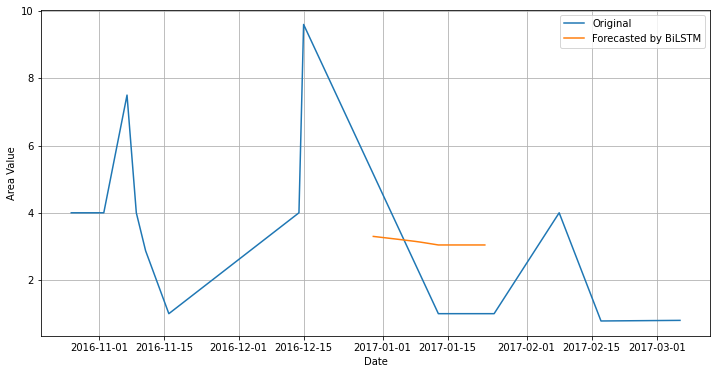

R square: 0.9847 

Wound: 2
Total number of visit days after interpolation 85
1/1 [==============================] - 0s 219ms/step
test_dates shape: (16,)
predicted_values_test_inverse shape: (16, 1)


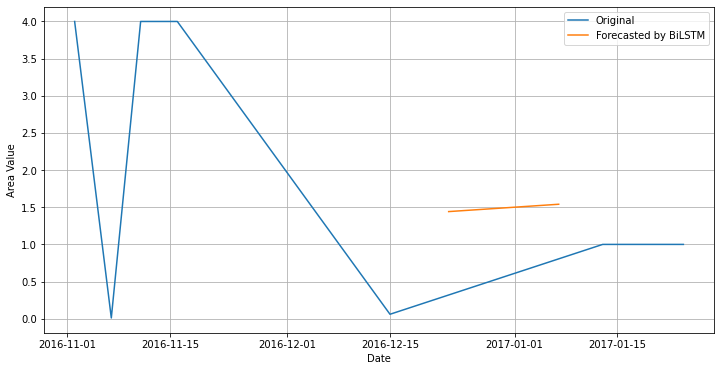

R square: 1.0 

Wound: 3
Total number of visit days after interpolation 13
1/1 [==============================] - 0s 241ms/step
test_dates shape: (1,)
predicted_values_test_inverse shape: (1, 1)


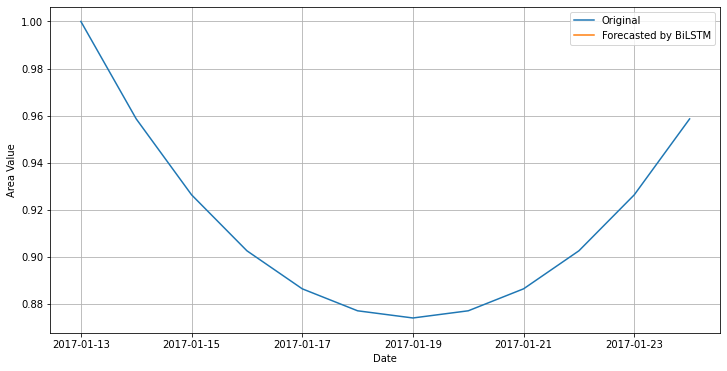

R square: nan 

Wound: 4
Total number of visit days after interpolation 16
1/1 [==============================] - 0s 220ms/step
test_dates shape: (2,)
predicted_values_test_inverse shape: (2, 1)


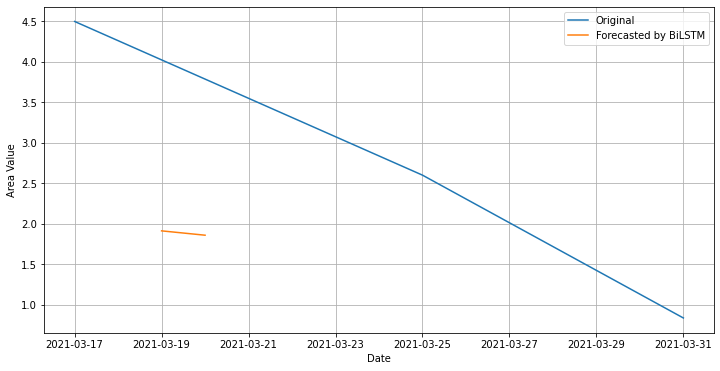

R square: 1.0 

Wound: 5
Total number of visit days after interpolation 16
1/1 [==============================] - 0s 218ms/step
test_dates shape: (2,)
predicted_values_test_inverse shape: (2, 1)


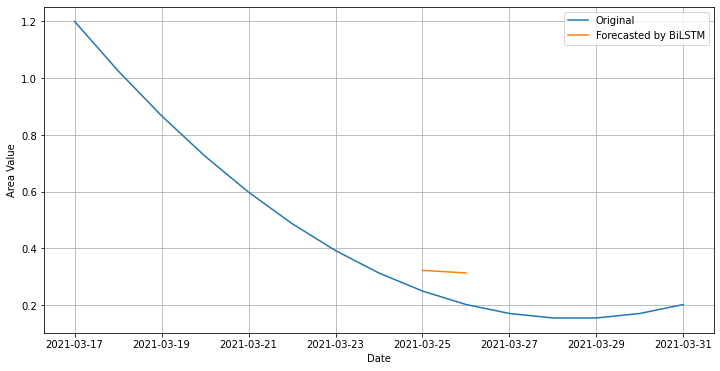

R square: 1.0 

Wound: 6
Total number of visit days after interpolation 344
3/3 [==============================] - 0s 1ms/step
test_dates shape: (67,)
predicted_values_test_inverse shape: (67, 1)


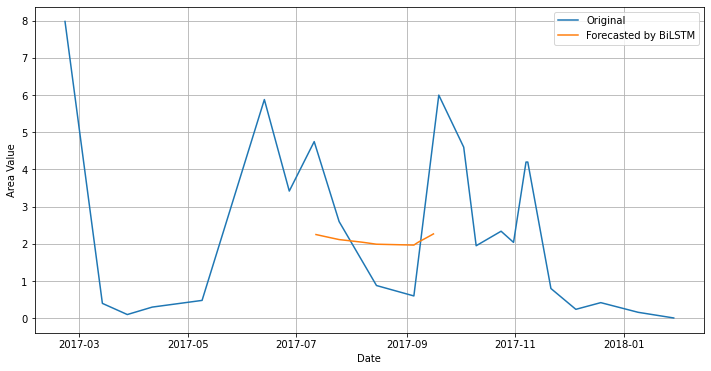

R square: 0.978 

Wound: 7
Total number of visit days after interpolation 15
1/1 [==============================] - 0s 217ms/step
test_dates shape: (2,)
predicted_values_test_inverse shape: (2, 1)


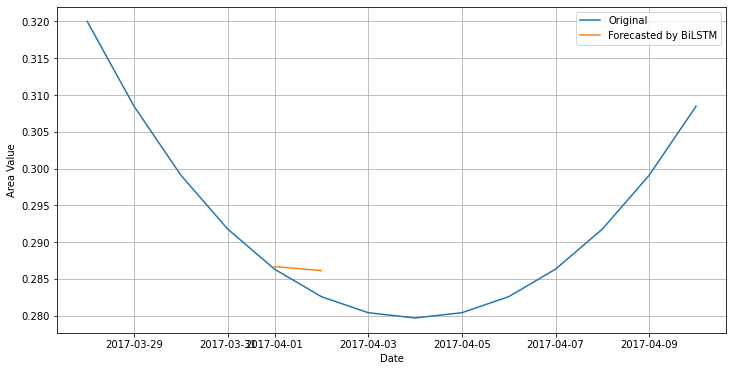

R square: 1.0 

Wound: 8
Total number of visit days after interpolation 36
1/1 [==============================] - 0s 216ms/step
test_dates shape: (6,)
predicted_values_test_inverse shape: (6, 1)


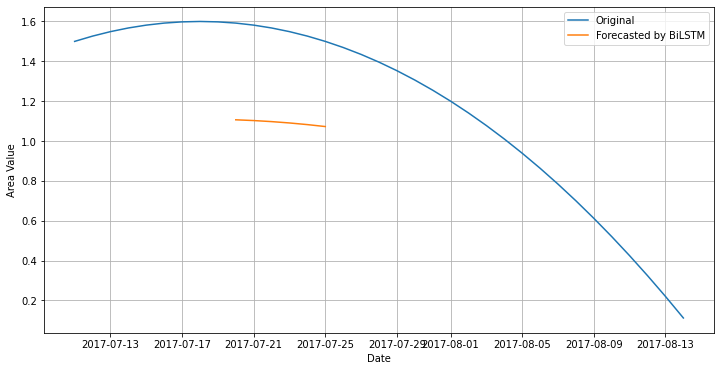

R square: 0.9992 

Wound: 9
Total number of visit days after interpolation 253
2/2 [==============================] - 0s 2ms/step
test_dates shape: (49,)
predicted_values_test_inverse shape: (49, 1)


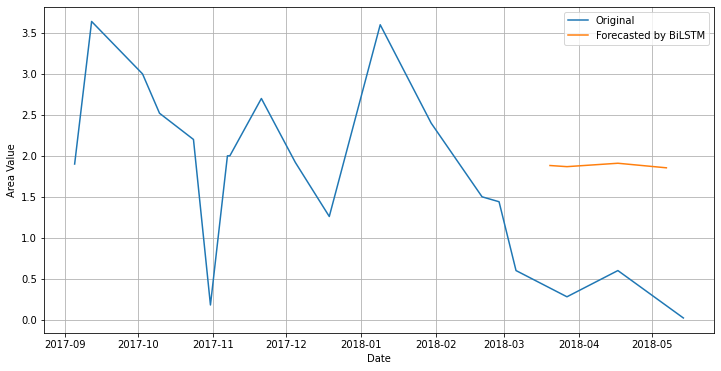

R square: 0.9783 

Wound: 10
Total number of visit days after interpolation 148
1/1 [==============================] - 0s 208ms/step
test_dates shape: (28,)
predicted_values_test_inverse shape: (28, 1)


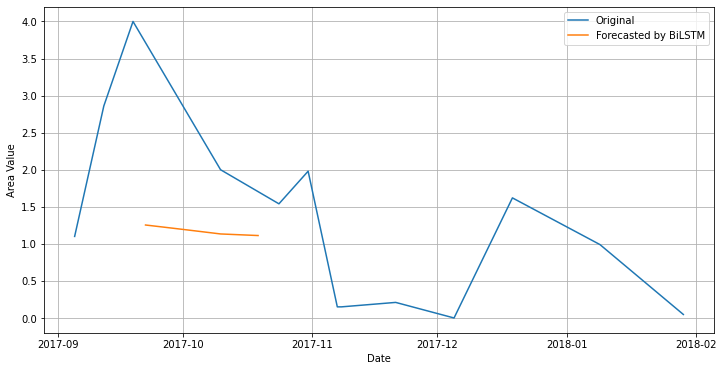

R square: 0.9987 

Wound: 11
Total number of visit days after interpolation 43
1/1 [==============================] - 0s 211ms/step
test_dates shape: (7,)
predicted_values_test_inverse shape: (7, 1)


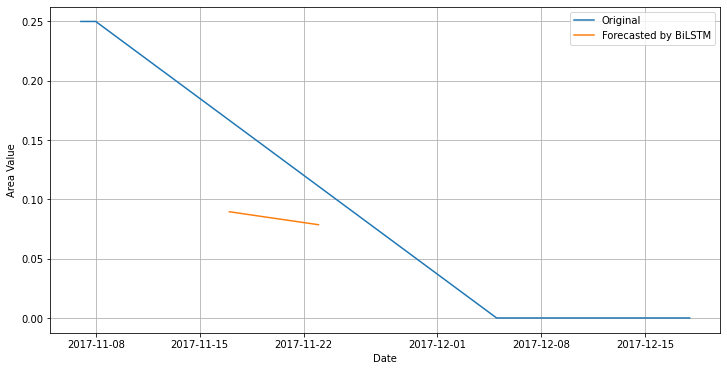

R square: 1.0 

Wound: 12
Total number of visit days after interpolation 15
1/1 [==============================] - 0s 215ms/step
test_dates shape: (2,)
predicted_values_test_inverse shape: (2, 1)


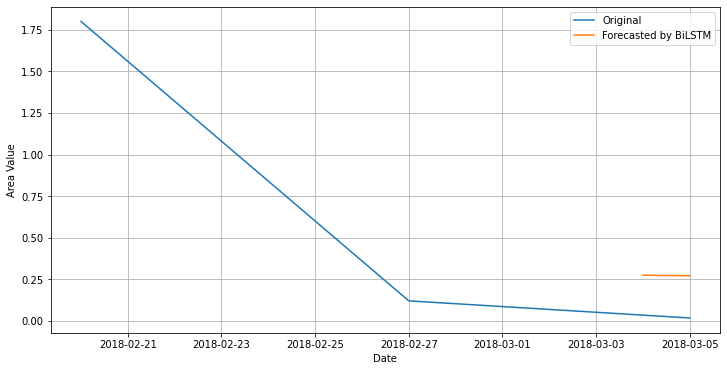

R square: 1.0 

Wound: 13
Total number of visit days after interpolation 533
4/4 [==============================] - 0s 930us/step
test_dates shape: (105,)
predicted_values_test_inverse shape: (105, 1)


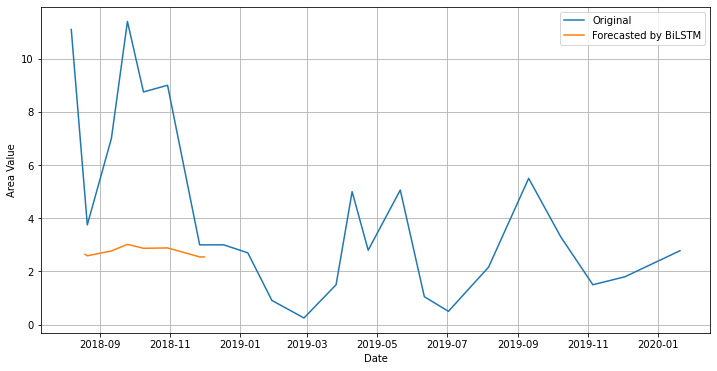

R square: 0.9929 

Wound: 14
Total number of visit days after interpolation 85
1/1 [==============================] - 0s 221ms/step
test_dates shape: (16,)
predicted_values_test_inverse shape: (16, 1)


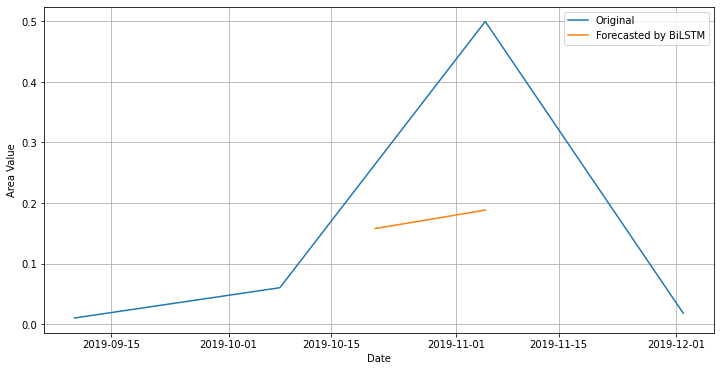

R square: 0.9883 

Wound: 15
Total number of visit days after interpolation 263
2/2 [==============================] - 0s 2ms/step
test_dates shape: (51,)
predicted_values_test_inverse shape: (51, 1)


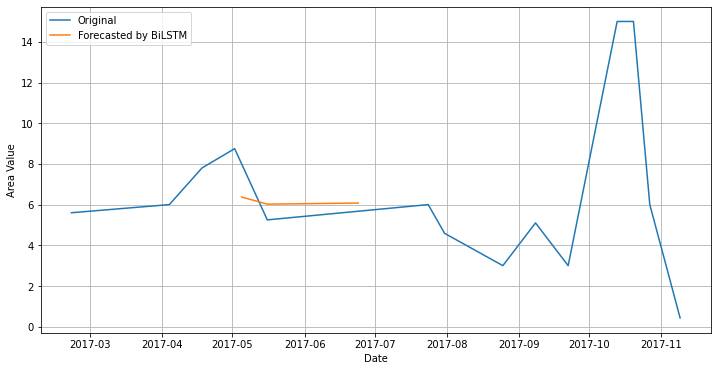

R square: 0.9873 

Wound: 16
Total number of visit days after interpolation 36
1/1 [==============================] - 0s 212ms/step
test_dates shape: (6,)
predicted_values_test_inverse shape: (6, 1)


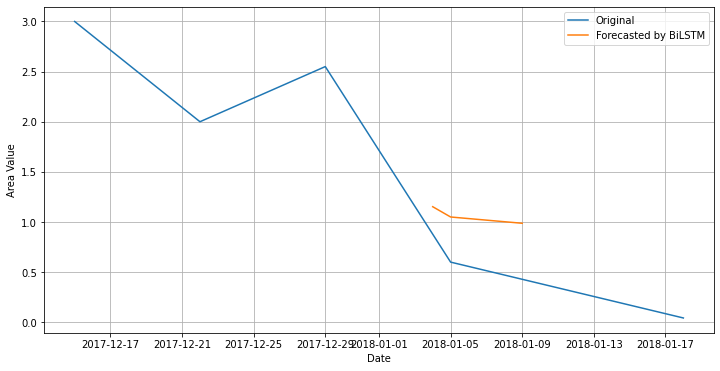

R square: 0.7931 

Wound: 17
Total number of visit days after interpolation 75
1/1 [==============================] - 0s 218ms/step
test_dates shape: (14,)
predicted_values_test_inverse shape: (14, 1)


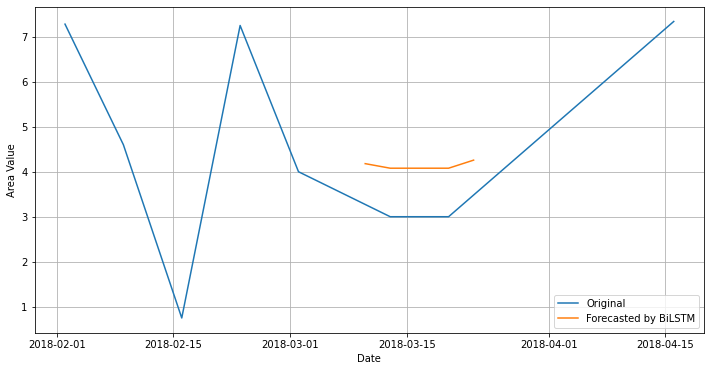

R square: 0.8145 

Wound: 18
Total number of visit days after interpolation 15
1/1 [==============================] - 0s 220ms/step
test_dates shape: (2,)
predicted_values_test_inverse shape: (2, 1)


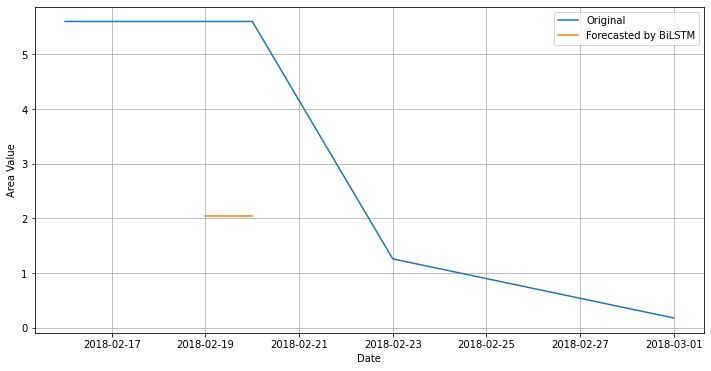

R square: nan 

Wound: 19
Total number of visit days after interpolation 57
1/1 [==============================] - 0s 218ms/step
test_dates shape: (10,)
predicted_values_test_inverse shape: (10, 1)


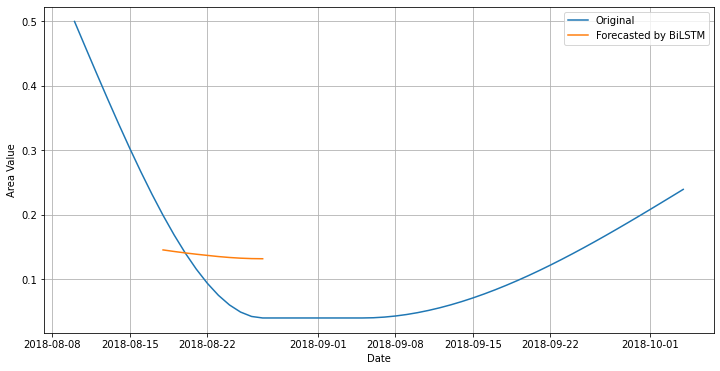

R square: 0.9878 

Wound: 20
Total number of visit days after interpolation 316
2/2 [==============================] - 0s 2ms/step
test_dates shape: (62,)
predicted_values_test_inverse shape: (62, 1)


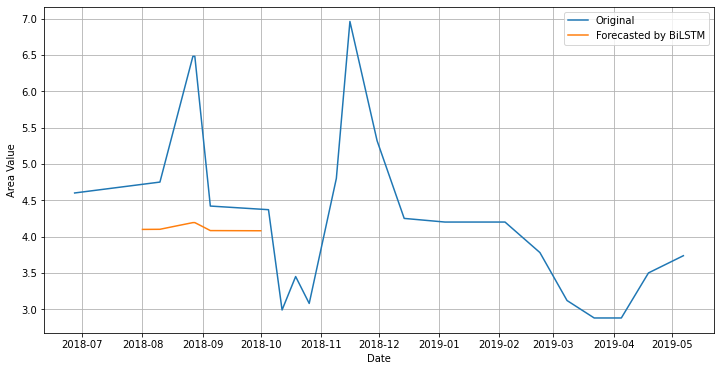

R square: 0.9748 

Wound: 21
Total number of visit days after interpolation 115
1/1 [==============================] - 0s 220ms/step
test_dates shape: (22,)
predicted_values_test_inverse shape: (22, 1)


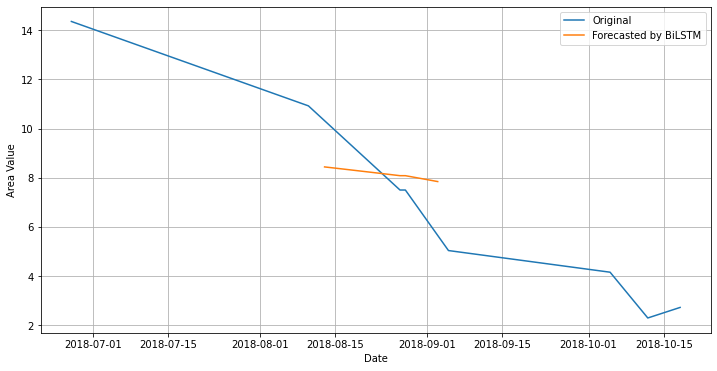

R square: 0.9983 

Wound: 22
Total number of visit days after interpolation 57
1/1 [==============================] - 0s 229ms/step
test_dates shape: (10,)
predicted_values_test_inverse shape: (10, 1)


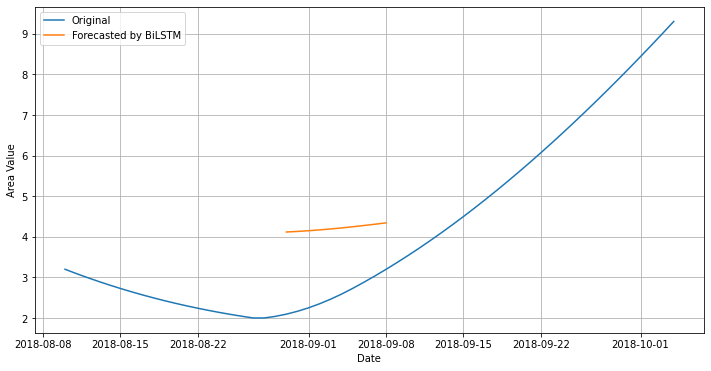

R square: 0.9994 

Wound: 23
Total number of visit days after interpolation 57
1/1 [==============================] - 0s 221ms/step
test_dates shape: (10,)
predicted_values_test_inverse shape: (10, 1)


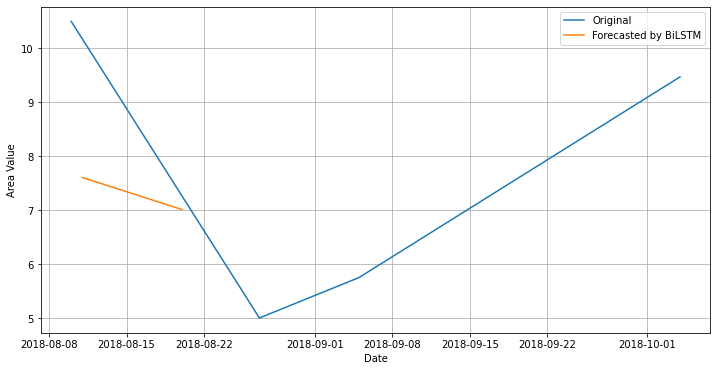

R square: 1.0 

Wound: 24
Total number of visit days after interpolation 141
1/1 [==============================] - 0s 218ms/step
test_dates shape: (27,)
predicted_values_test_inverse shape: (27, 1)


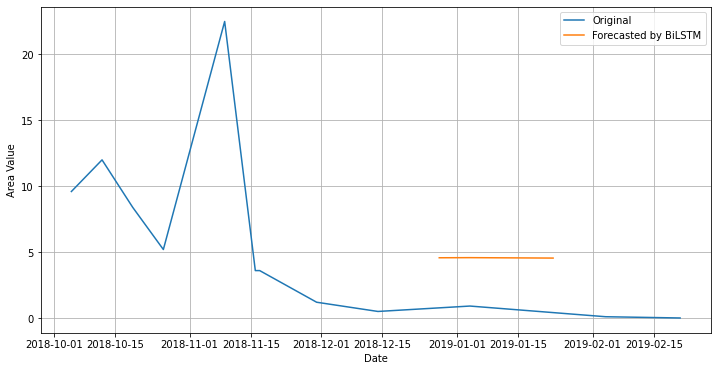

R square: 0.9884 

Wound: 25
Total number of visit days after interpolation 181
2/2 [==============================] - 0s 2ms/step
test_dates shape: (35,)
predicted_values_test_inverse shape: (35, 1)


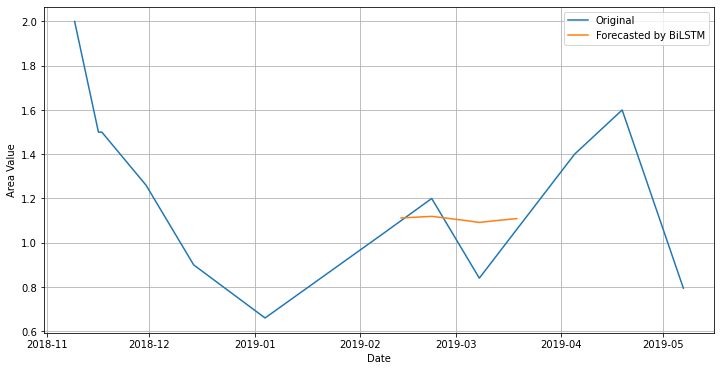

R square: 0.962 

Wound: 26
Total number of visit days after interpolation 477
3/3 [==============================] - 0s 1ms/step
test_dates shape: (94,)
predicted_values_test_inverse shape: (94, 1)


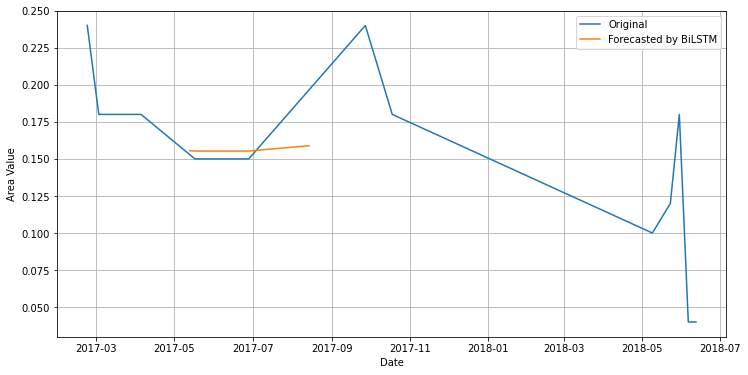

R square: 0.9996 

Wound: 27
Total number of visit days after interpolation 181
2/2 [==============================] - 0s 2ms/step
test_dates shape: (35,)
predicted_values_test_inverse shape: (35, 1)


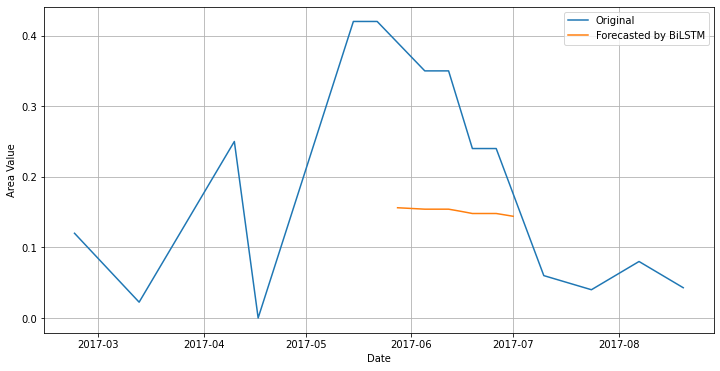

R square: 0.9905 

Wound: 28
Total number of visit days after interpolation 85
1/1 [==============================] - 0s 226ms/step
test_dates shape: (16,)
predicted_values_test_inverse shape: (16, 1)


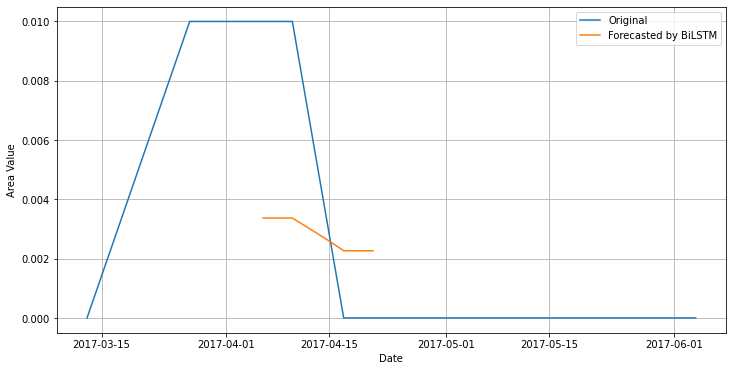

R square: 0.9683 

Wound: 29
Total number of visit days after interpolation 43
1/1 [==============================] - 0s 214ms/step
test_dates shape: (7,)
predicted_values_test_inverse shape: (7, 1)


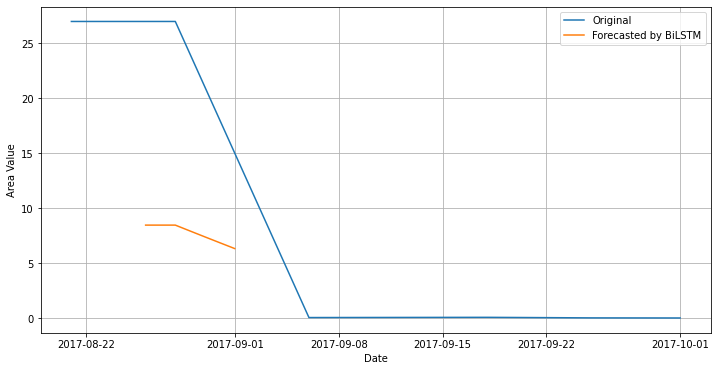

R square: 0.9609 

Wound: 30
Total number of visit days after interpolation 71
1/1 [==============================] - 0s 211ms/step
test_dates shape: (13,)
predicted_values_test_inverse shape: (13, 1)


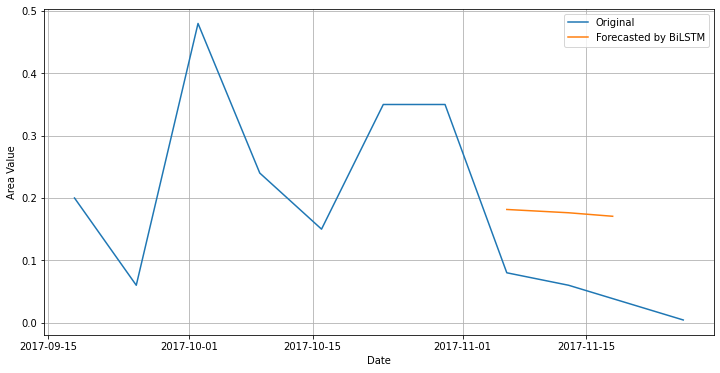

R square: 0.9993 

Wound: 31
Total number of visit days after interpolation 22
1/1 [==============================] - 0s 219ms/step
test_dates shape: (3,)
predicted_values_test_inverse shape: (3, 1)


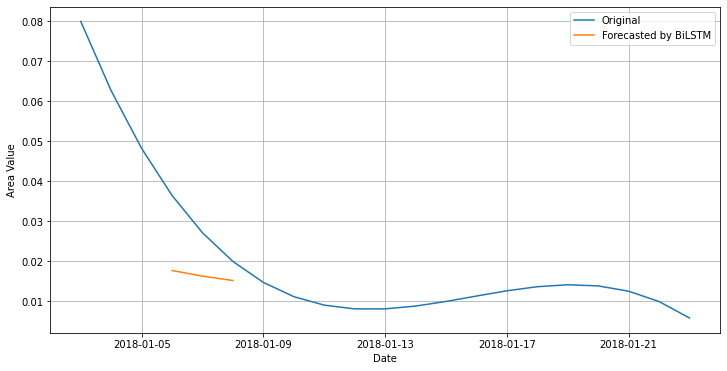

R square: 0.9996 

Wound: 32
Total number of visit days after interpolation 155
1/1 [==============================] - 0s 227ms/step
test_dates shape: (30,)
predicted_values_test_inverse shape: (30, 1)


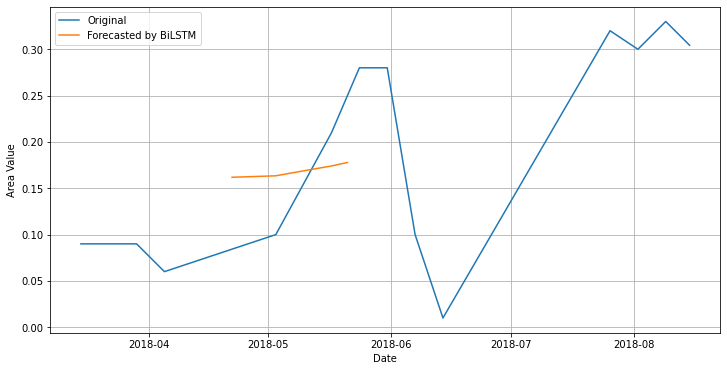

R square: 0.9991 

Wound: 33
Total number of visit days after interpolation 22
1/1 [==============================] - 0s 222ms/step
test_dates shape: (3,)
predicted_values_test_inverse shape: (3, 1)


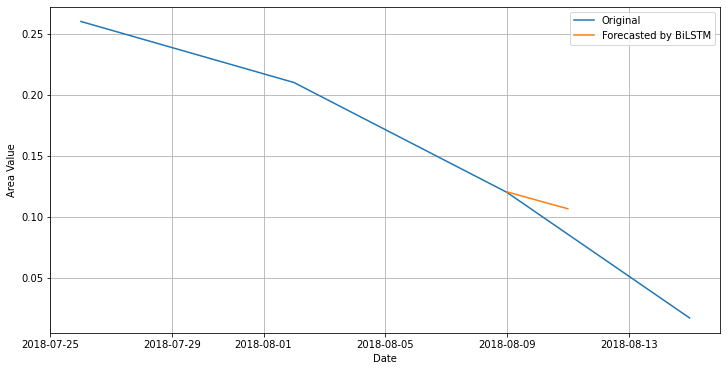

R square: 1.0 

Wound: 34
Total number of visit days after interpolation 490
4/4 [==============================] - 0s 993us/step
test_dates shape: (97,)
predicted_values_test_inverse shape: (97, 1)


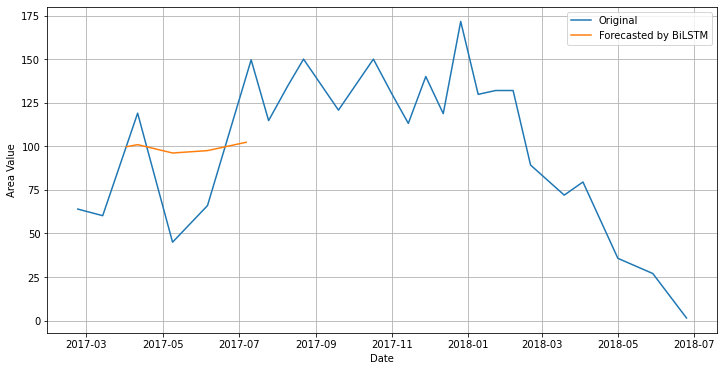

R square: 0.9946 

Wound: 35
Total number of visit days after interpolation 113
1/1 [==============================] - 0s 219ms/step
test_dates shape: (21,)
predicted_values_test_inverse shape: (21, 1)


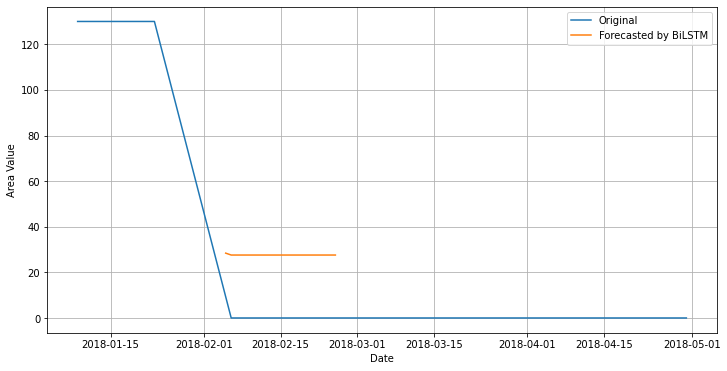

R square: nan 

Wound: 36
Total number of visit days after interpolation 29
1/1 [==============================] - 0s 221ms/step
test_dates shape: (4,)
predicted_values_test_inverse shape: (4, 1)


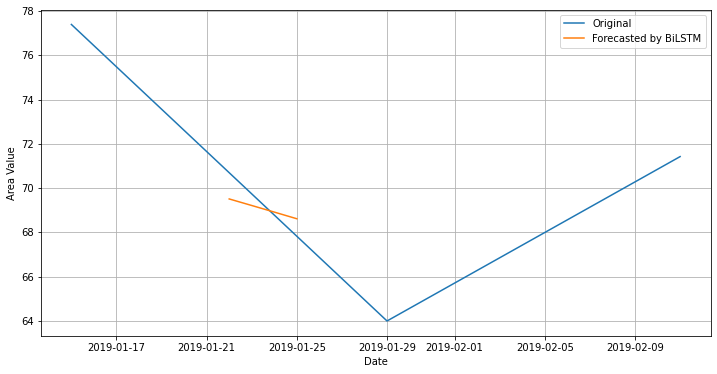

R square: 1.0 

Wound: 37
Total number of visit days after interpolation 164
1/1 [==============================] - 0s 221ms/step
test_dates shape: (31,)
predicted_values_test_inverse shape: (31, 1)


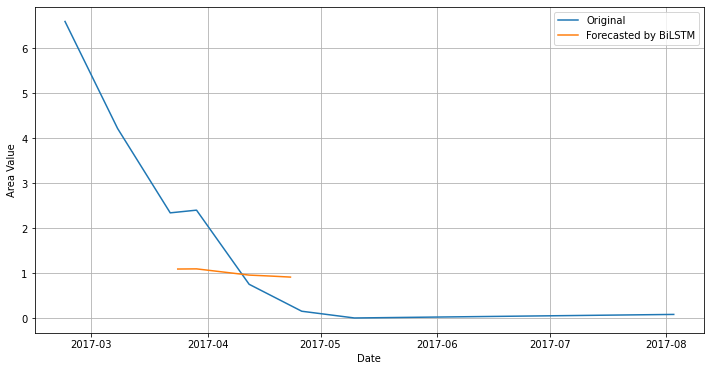

R square: 0.9951 

Wound: 38
Total number of visit days after interpolation 120
1/1 [==============================] - 0s 216ms/step
test_dates shape: (23,)
predicted_values_test_inverse shape: (23, 1)


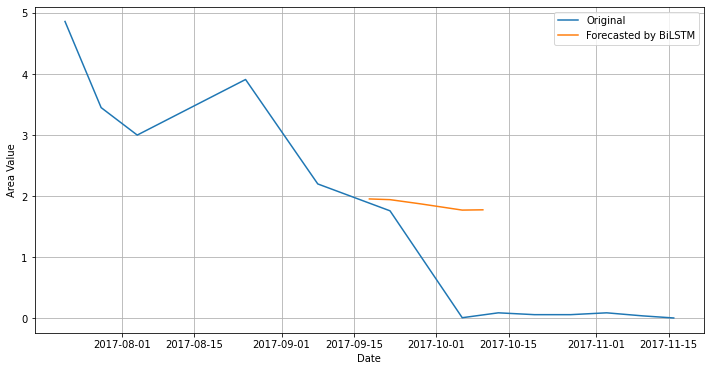

R square: 0.9904 

Wound: 39
Total number of visit days after interpolation 148
1/1 [==============================] - 0s 218ms/step
test_dates shape: (28,)
predicted_values_test_inverse shape: (28, 1)


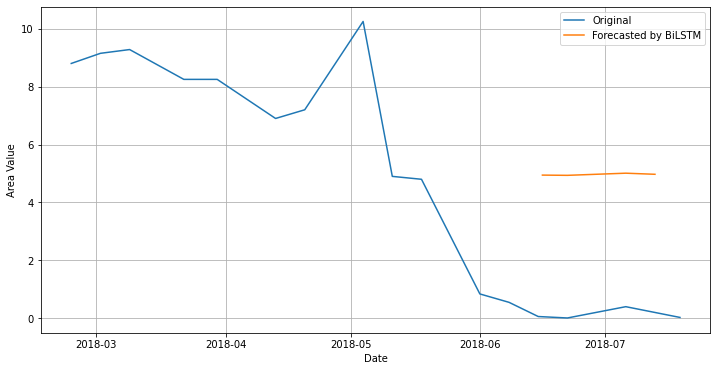

R square: 0.962 

Wound: 40
Total number of visit days after interpolation 43
1/1 [==============================] - 0s 218ms/step
test_dates shape: (7,)
predicted_values_test_inverse shape: (7, 1)


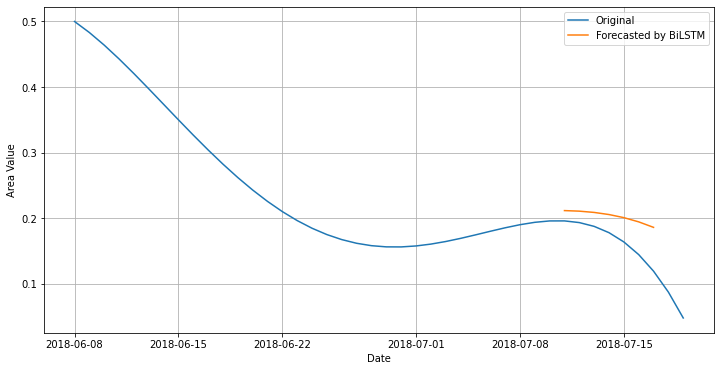

R square: 0.9977 

Wound: 41
Total number of visit days after interpolation 15
1/1 [==============================] - 0s 252ms/step
test_dates shape: (2,)
predicted_values_test_inverse shape: (2, 1)


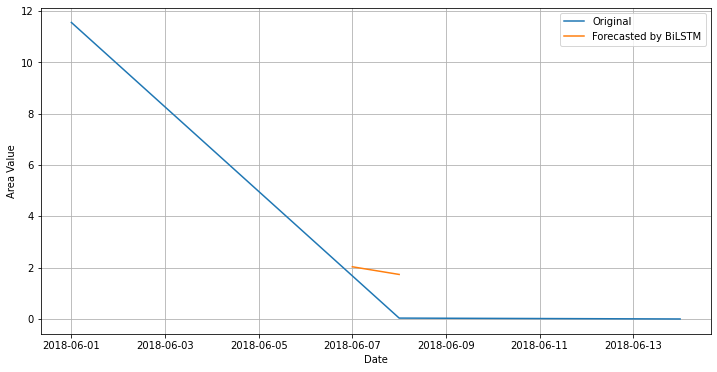

R square: 1.0 

Wound: 42
Total number of visit days after interpolation 48
1/1 [==============================] - 0s 223ms/step
test_dates shape: (8,)
predicted_values_test_inverse shape: (8, 1)


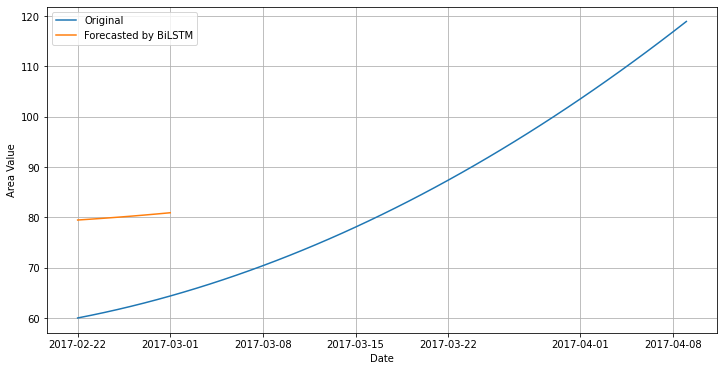

R square: 1.0 

Wound: 43
Total number of visit days after interpolation 59
1/1 [==============================] - 0s 227ms/step
test_dates shape: (10,)
predicted_values_test_inverse shape: (10, 1)


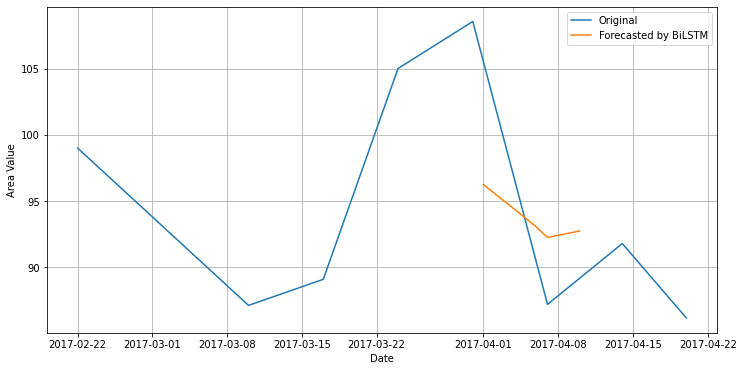

R square: 0.935 

Wound: 44
Total number of visit days after interpolation 64
1/1 [==============================] - 0s 221ms/step
test_dates shape: (11,)
predicted_values_test_inverse shape: (11, 1)


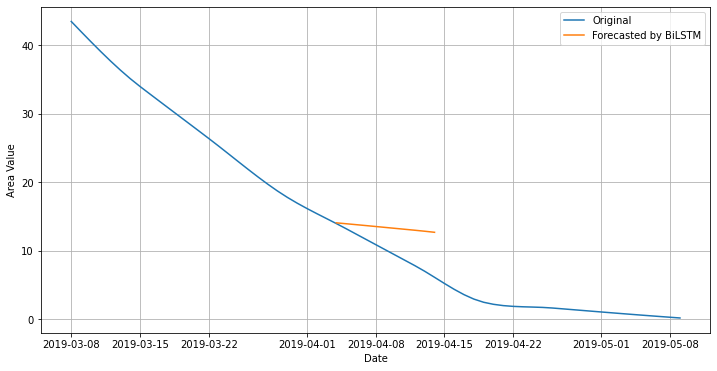

R square: 0.9999 

Wound: 45
Total number of visit days after interpolation 36
1/1 [==============================] - 0s 220ms/step
test_dates shape: (6,)
predicted_values_test_inverse shape: (6, 1)


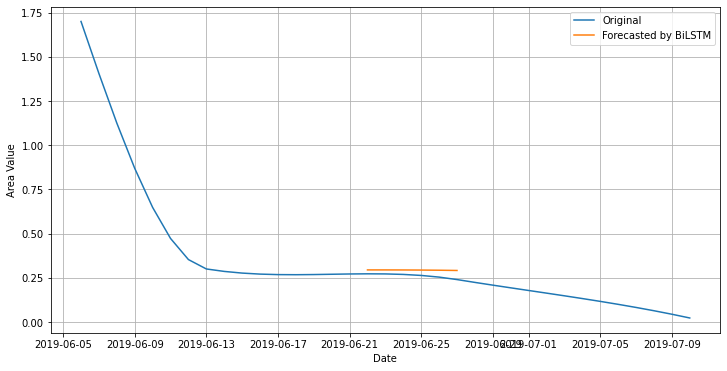

R square: 0.9866 

Wound: 46
Total number of visit days after interpolation 49
1/1 [==============================] - 0s 217ms/step
test_dates shape: (8,)
predicted_values_test_inverse shape: (8, 1)


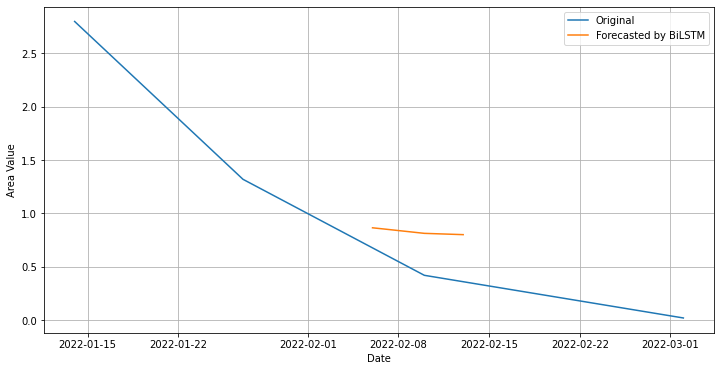

R square: 0.9854 

Wound: 47
Total number of visit days after interpolation 76
1/1 [==============================] - 0s 215ms/step
test_dates shape: (14,)
predicted_values_test_inverse shape: (14, 1)


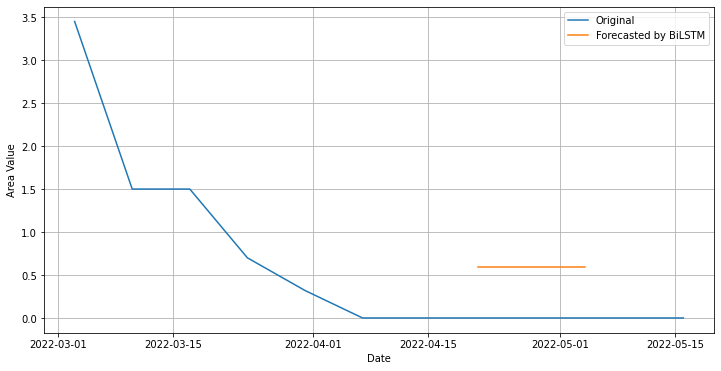

R square: nan 

Wound: 48
Total number of visit days after interpolation 113
1/1 [==============================] - 0s 223ms/step
test_dates shape: (21,)
predicted_values_test_inverse shape: (21, 1)


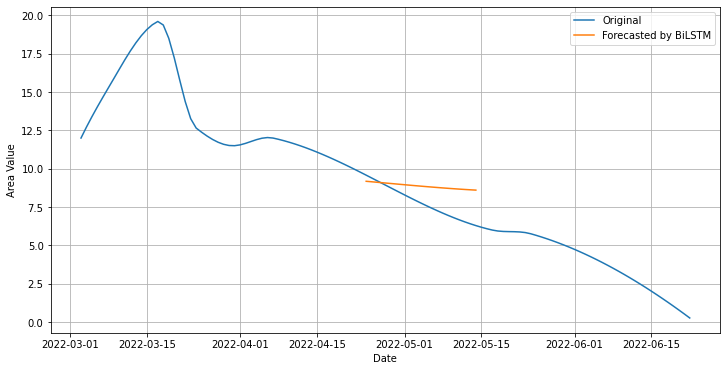

R square: 0.9999 

Wound: 49
Total number of visit days after interpolation 106
1/1 [==============================] - 0s 216ms/step
test_dates shape: (20,)
predicted_values_test_inverse shape: (20, 1)


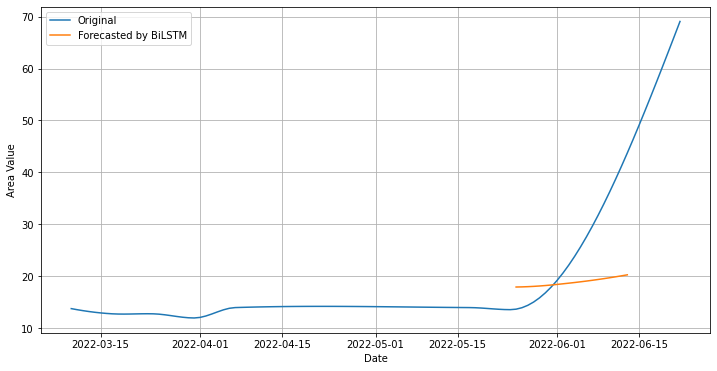

R square: 0.9998 

Wound: 50
Total number of visit days after interpolation 50
1/1 [==============================] - 0s 222ms/step
test_dates shape: (9,)
predicted_values_test_inverse shape: (9, 1)


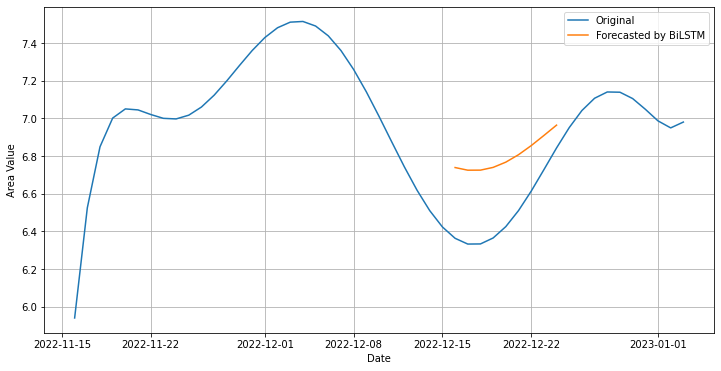

R square: 0.9756 

Wound: 51
Total number of visit days after interpolation 57
1/1 [==============================] - 0s 222ms/step
test_dates shape: (10,)
predicted_values_test_inverse shape: (10, 1)


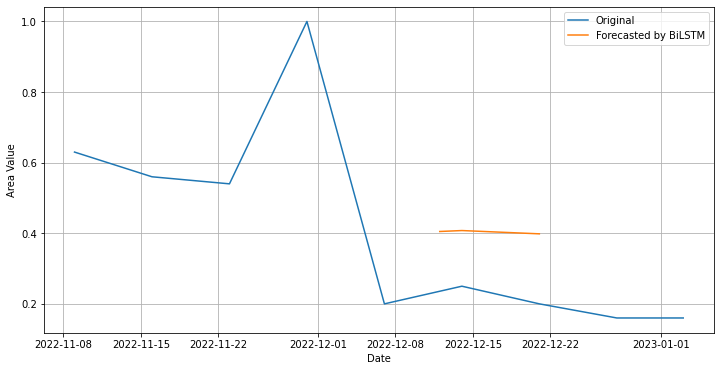

R square: 0.9152 

Wound: 52
Total number of visit days after interpolation 22
1/1 [==============================] - 0s 235ms/step
test_dates shape: (3,)
predicted_values_test_inverse shape: (3, 1)


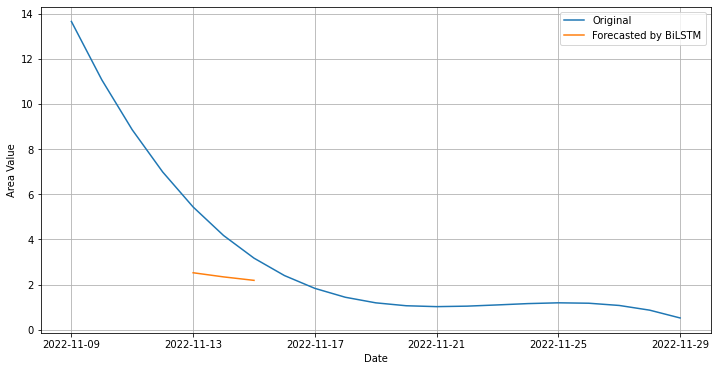

R square: 0.9994 

Wound: 53
Total number of visit days after interpolation 36
1/1 [==============================] - 0s 221ms/step
test_dates shape: (6,)
predicted_values_test_inverse shape: (6, 1)


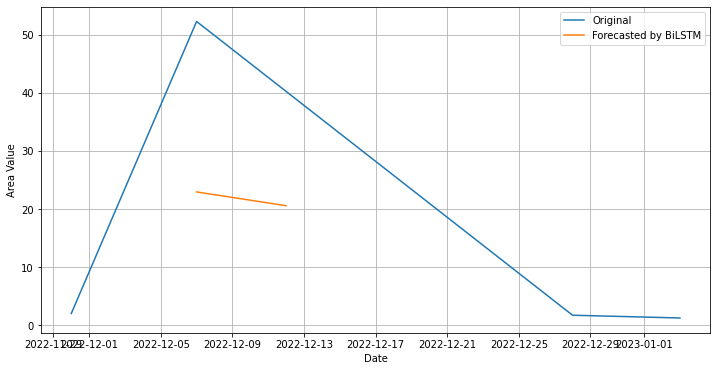

R square: 1.0 

Wound: 54
Total number of visit days after interpolation 15
1/1 [==============================] - 0s 220ms/step
test_dates shape: (2,)
predicted_values_test_inverse shape: (2, 1)


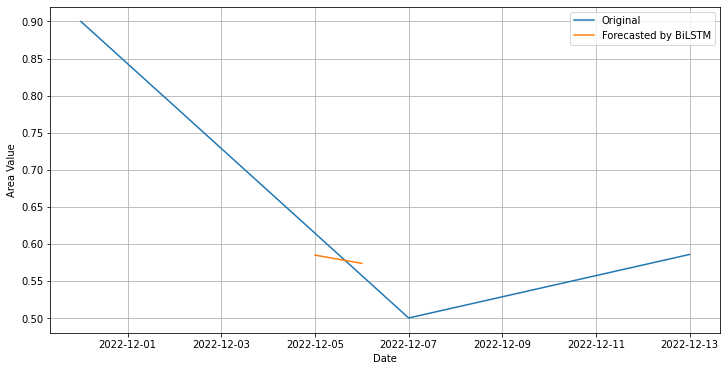

R square: 1.0 

Wound: 55
Wound: 56
Total number of visit days after interpolation 154
1/1 [==============================] - 0s 219ms/step
test_dates shape: (29,)
predicted_values_test_inverse shape: (29, 1)


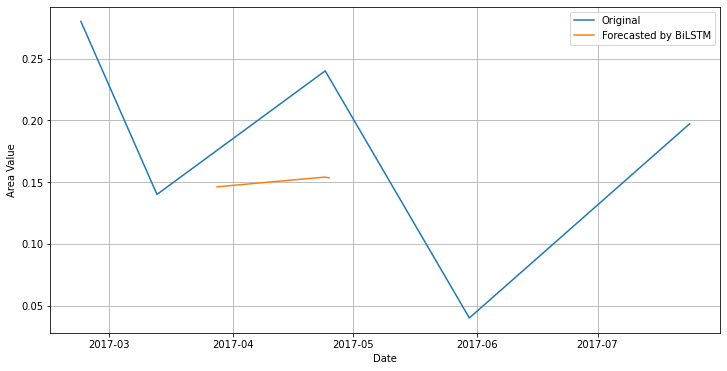

R square: 0.9908 

Wound: 57
Total number of visit days after interpolation 62
1/1 [==============================] - 0s 228ms/step
test_dates shape: (11,)
predicted_values_test_inverse shape: (11, 1)


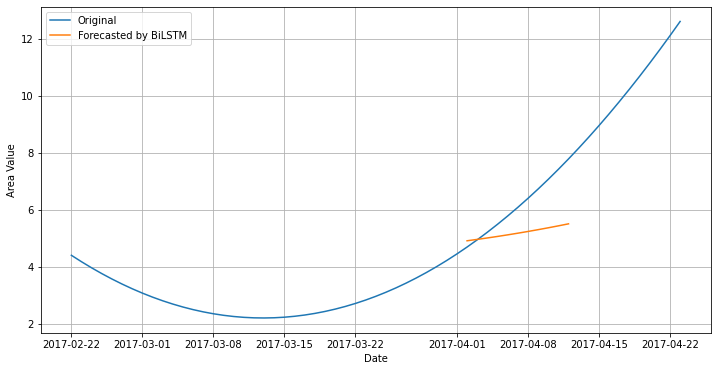

R square: 1.0 

Wound: 58
Total number of visit days after interpolation 154
1/1 [==============================] - 0s 221ms/step
test_dates shape: (29,)
predicted_values_test_inverse shape: (29, 1)


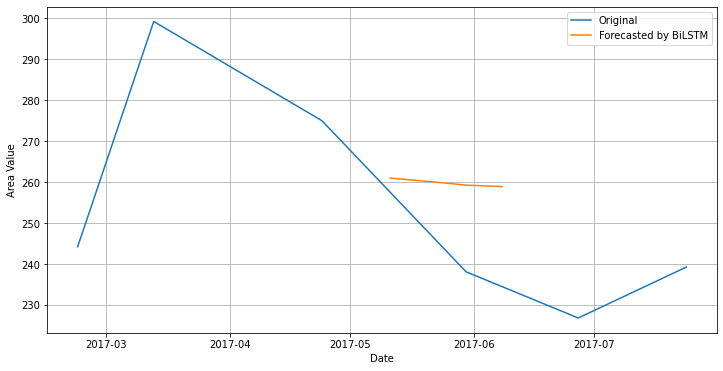

R square: 0.9973 

Wound: 59
Total number of visit days after interpolation 135
1/1 [==============================] - 0s 213ms/step
test_dates shape: (26,)
predicted_values_test_inverse shape: (26, 1)


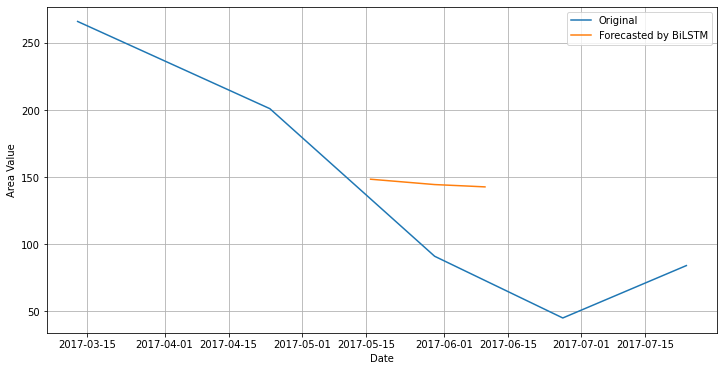

R square: 0.9995 

Wound: 60
Total number of visit days after interpolation 135
1/1 [==============================] - 0s 221ms/step
test_dates shape: (26,)
predicted_values_test_inverse shape: (26, 1)


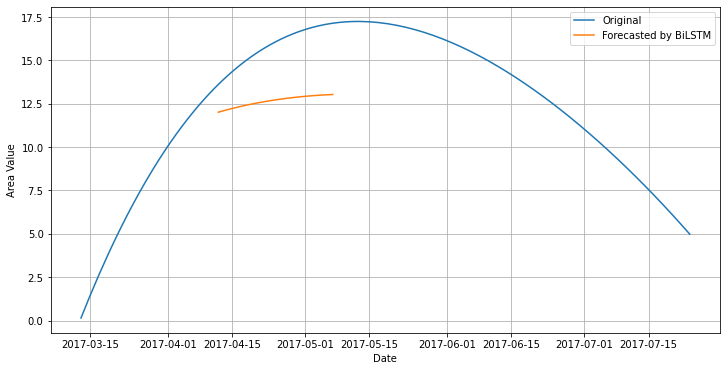

R square: 0.9999 

Wound: 61
Wound: 62
Total number of visit days after interpolation 135
1/1 [==============================] - 1s 1s/step
test_dates shape: (26,)
predicted_values_test_inverse shape: (26, 1)


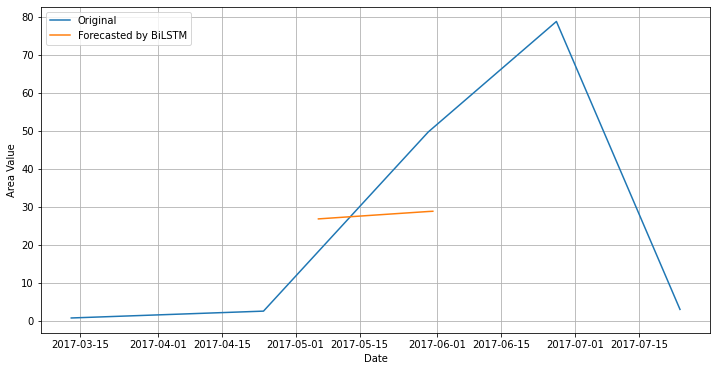

R square: 1.0 

Wound: 63
Total number of visit days after interpolation 93
1/1 [==============================] - 0s 216ms/step
test_dates shape: (17,)
predicted_values_test_inverse shape: (17, 1)


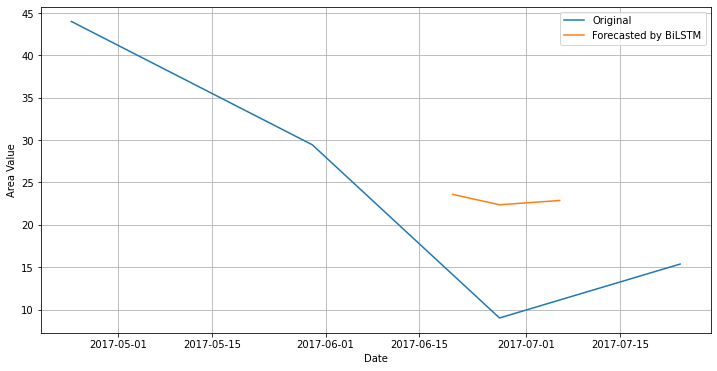

R square: 0.9027 

Wound: 64
Total number of visit days after interpolation 57
1/1 [==============================] - 0s 219ms/step
test_dates shape: (10,)
predicted_values_test_inverse shape: (10, 1)


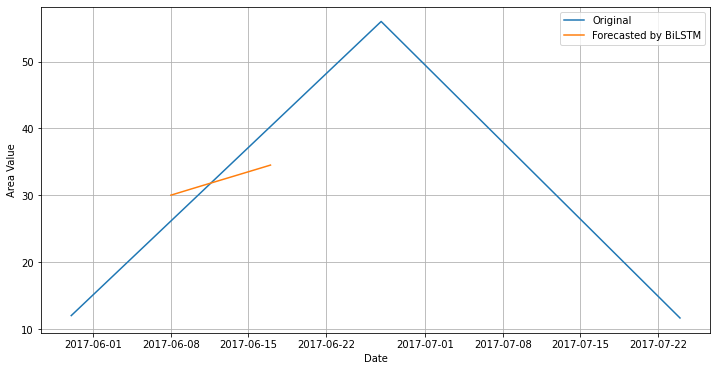

R square: 1.0 

Wound: 65
Total number of visit days after interpolation 667
5/5 [==============================] - 0s 964us/step
test_dates shape: (132,)
predicted_values_test_inverse shape: (132, 1)


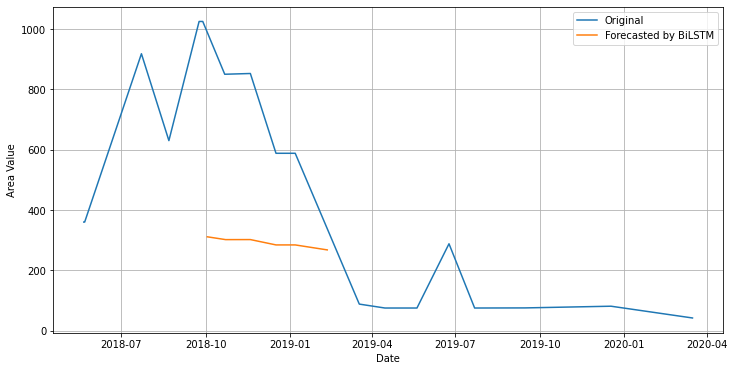

R square: 0.9995 

Wound: 66
Total number of visit days after interpolation 667
5/5 [==============================] - 0s 926us/step
test_dates shape: (132,)
predicted_values_test_inverse shape: (132, 1)


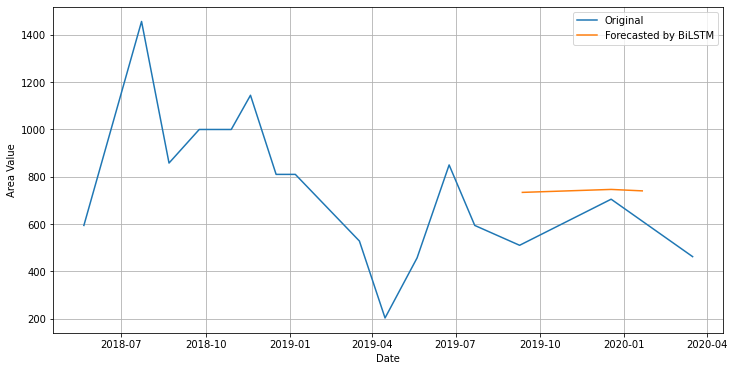

R square: 0.9987 

Wound: 67
Total number of visit days after interpolation 477
3/3 [==============================] - 0s 1ms/step
test_dates shape: (94,)
predicted_values_test_inverse shape: (94, 1)


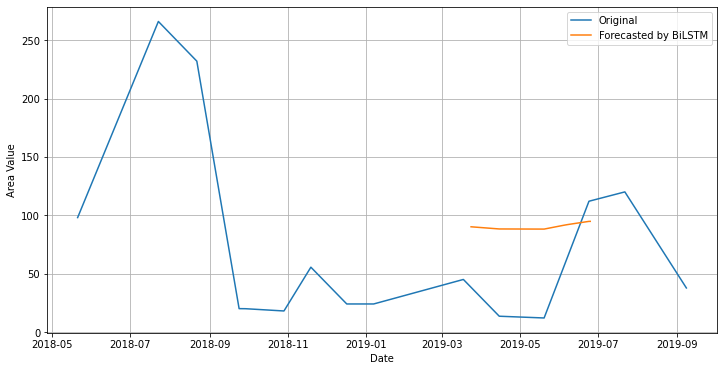

R square: 0.9969 

Wound: 68
Total number of visit days after interpolation 211
2/2 [==============================] - 0s 2ms/step
test_dates shape: (41,)
predicted_values_test_inverse shape: (41, 1)


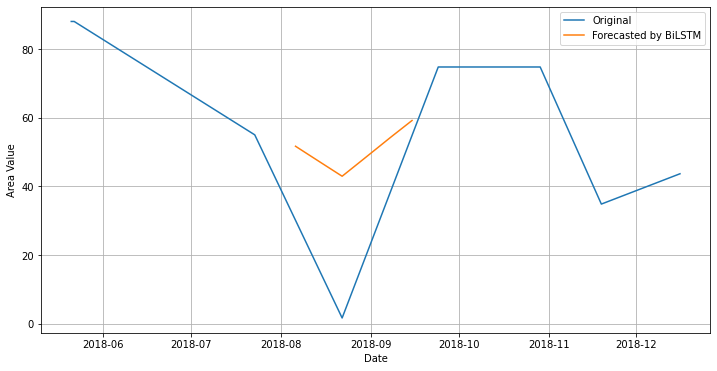

R square: 0.9864 

Wound: 69
Total number of visit days after interpolation 813
6/6 [==============================] - 0s 914us/step
test_dates shape: (161,)
predicted_values_test_inverse shape: (161, 1)


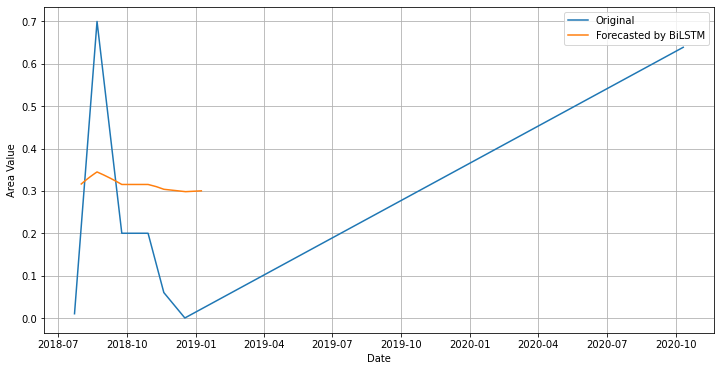

R square: 0.9861 

Wound: 70
Total number of visit days after interpolation 183
2/2 [==============================] - 0s 2ms/step
test_dates shape: (35,)
predicted_values_test_inverse shape: (35, 1)


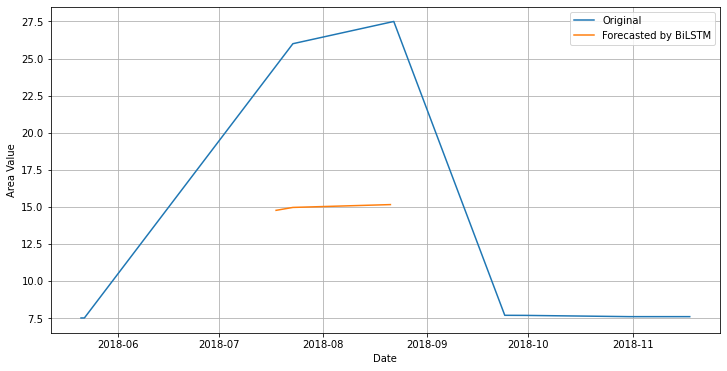

R square: 0.9934 

Wound: 71
Total number of visit days after interpolation 211
2/2 [==============================] - 0s 2ms/step
test_dates shape: (41,)
predicted_values_test_inverse shape: (41, 1)


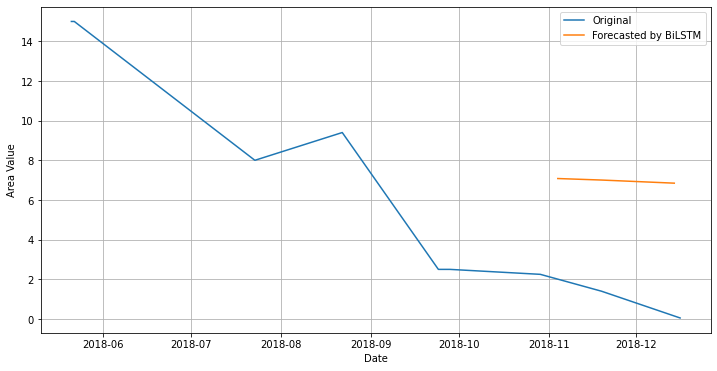

R square: 1.0 

Wound: 72
Total number of visit days after interpolation 91
1/1 [==============================] - 0s 229ms/step
test_dates shape: (17,)
predicted_values_test_inverse shape: (17, 1)


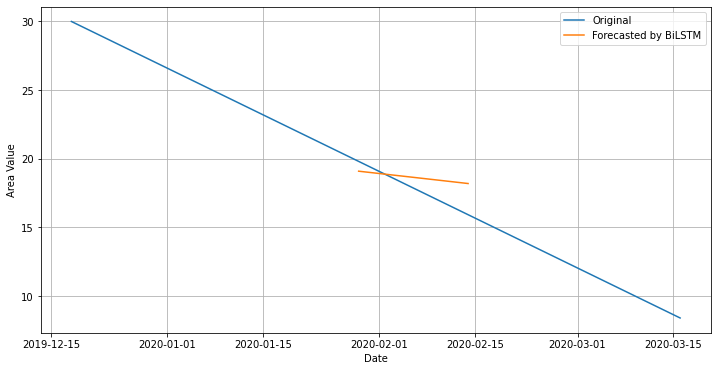

R square: 1.0 

Wound: 73
Total number of visit days after interpolation 91
1/1 [==============================] - 0s 228ms/step
test_dates shape: (17,)
predicted_values_test_inverse shape: (17, 1)


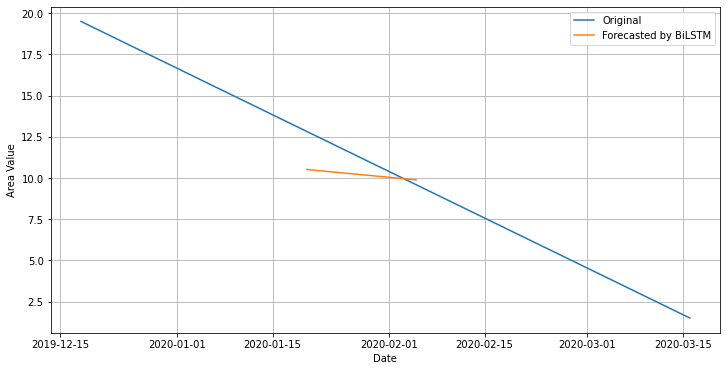

R square: 1.0 

Wound: 74
Total number of visit days after interpolation 91
1/1 [==============================] - 0s 213ms/step
test_dates shape: (17,)
predicted_values_test_inverse shape: (17, 1)


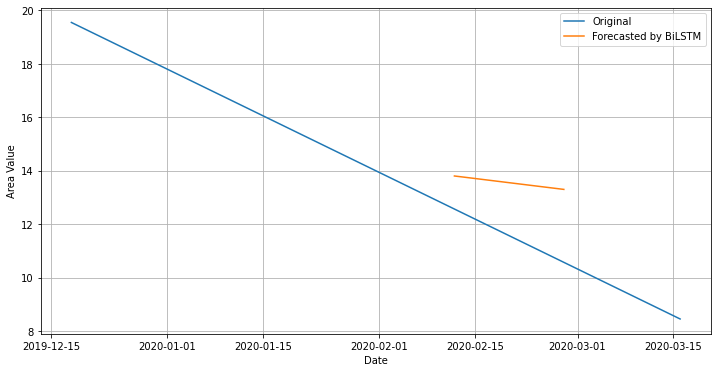

R square: 1.0 

Wound: 75
Wound: 76
Total number of visit days after interpolation 184
2/2 [==============================] - 0s 2ms/step
test_dates shape: (35,)
predicted_values_test_inverse shape: (35, 1)


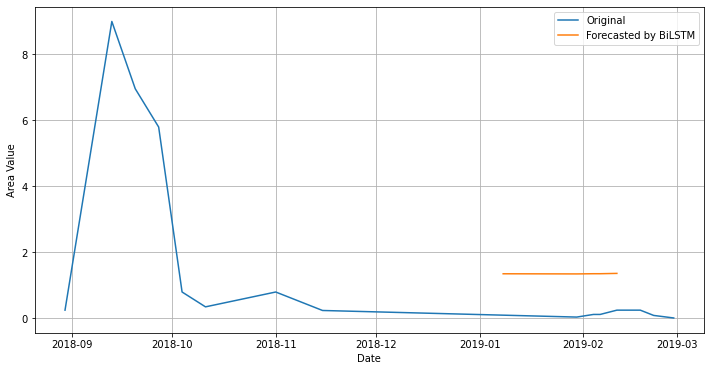

R square: 0.9726 

Wound: 77
Total number of visit days after interpolation 24
1/1 [==============================] - 0s 219ms/step
test_dates shape: (3,)
predicted_values_test_inverse shape: (3, 1)


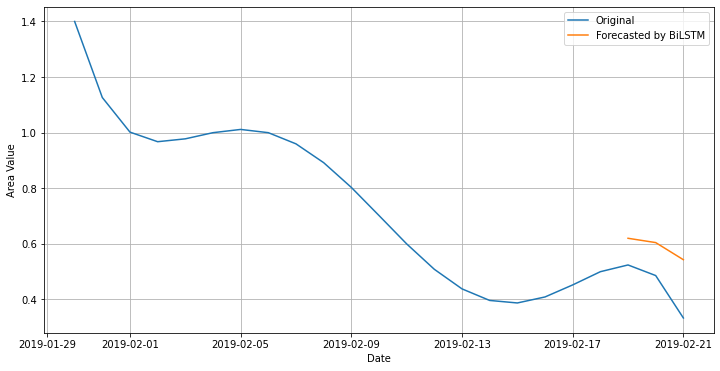

R square: 0.9855 

Wound: 78
Total number of visit days after interpolation 19
1/1 [==============================] - 0s 214ms/step
test_dates shape: (2,)
predicted_values_test_inverse shape: (2, 1)


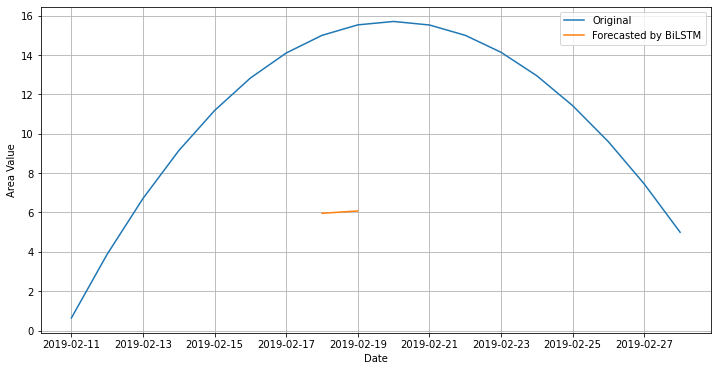

R square: 1.0 

Wound: 79
Wound: 80
Total number of visit days after interpolation 77
1/1 [==============================] - 0s 218ms/step
test_dates shape: (14,)
predicted_values_test_inverse shape: (14, 1)


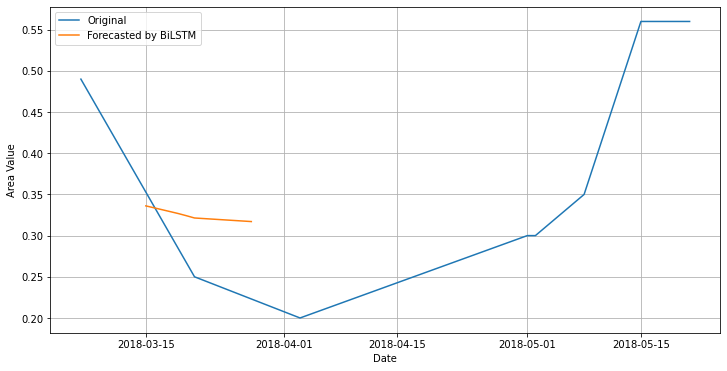

R square: 0.9861 

Wound: 81
Total number of visit days after interpolation 77
1/1 [==============================] - 0s 217ms/step
test_dates shape: (14,)
predicted_values_test_inverse shape: (14, 1)


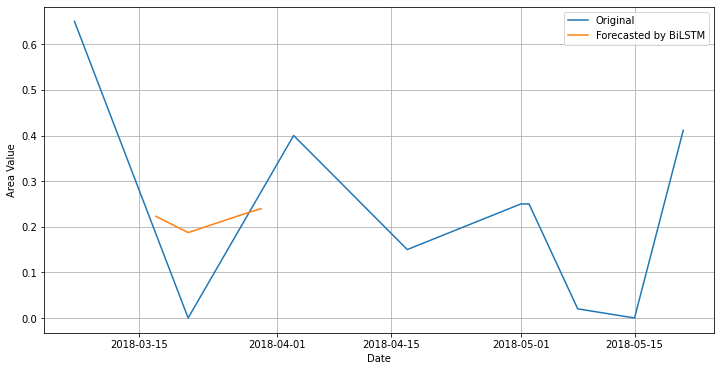

R square: 0.8549 

Wound: 82
Total number of visit days after interpolation 290
2/2 [==============================] - 0s 2ms/step
test_dates shape: (57,)
predicted_values_test_inverse shape: (57, 1)


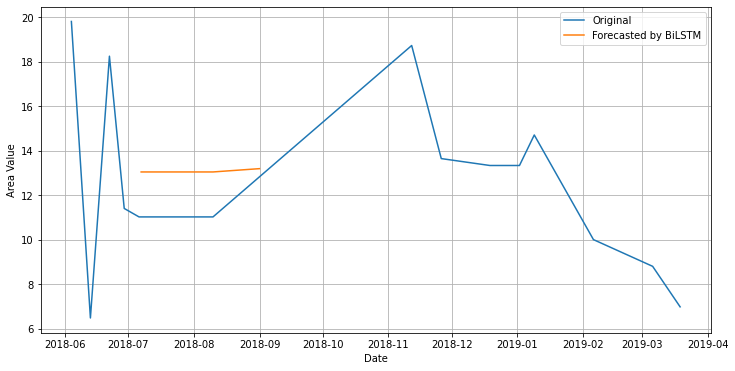

R square: 0.9984 

Wound: 83
Total number of visit days after interpolation 33
1/1 [==============================] - 1s 1s/step
test_dates shape: (5,)
predicted_values_test_inverse shape: (5, 1)


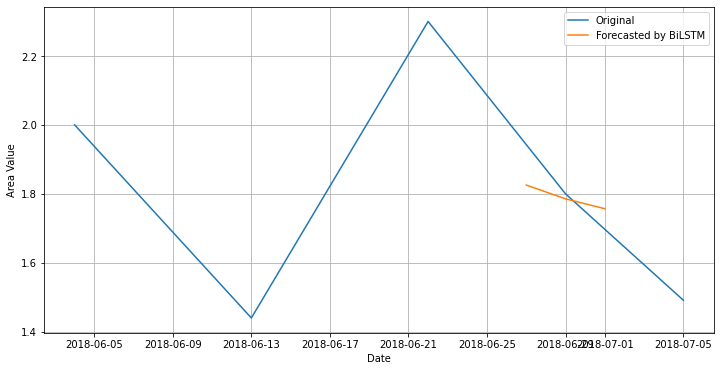

R square: 0.9967 

Wound: 84
Total number of visit days after interpolation 41
1/1 [==============================] - 0s 223ms/step
test_dates shape: (7,)
predicted_values_test_inverse shape: (7, 1)


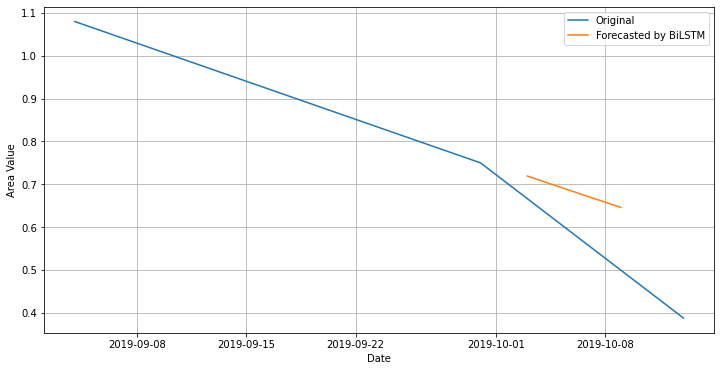

R square: 1.0 

Wound: 85
Total number of visit days after interpolation 41
1/1 [==============================] - 0s 223ms/step
test_dates shape: (7,)
predicted_values_test_inverse shape: (7, 1)


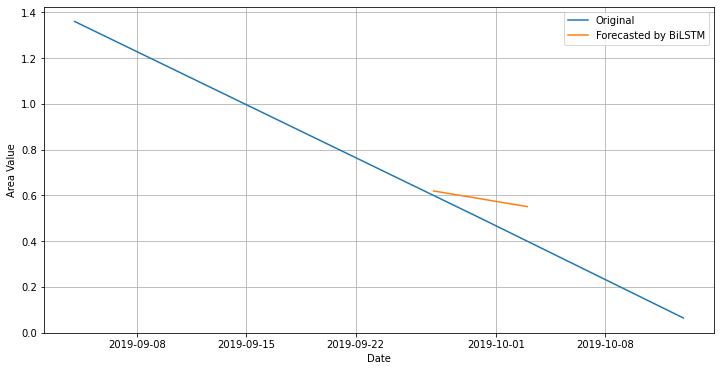

R square: 1.0 

Wound: 86
Wound: 87
Total number of visit days after interpolation 51
1/1 [==============================] - 0s 230ms/step
test_dates shape: (9,)
predicted_values_test_inverse shape: (9, 1)


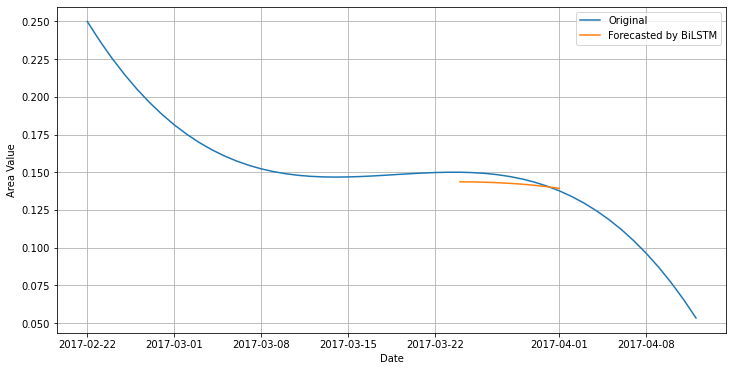

R square: 0.9983 

Wound: 88
Total number of visit days after interpolation 22
1/1 [==============================] - 0s 217ms/step
test_dates shape: (3,)
predicted_values_test_inverse shape: (3, 1)


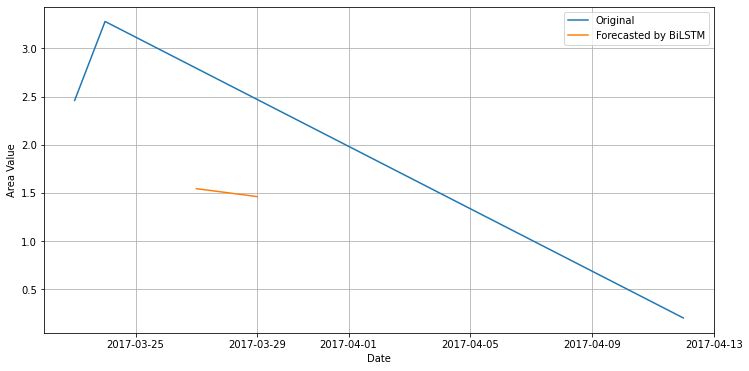

R square: 1.0 

Wound: 89
Total number of visit days after interpolation 15
1/1 [==============================] - 0s 215ms/step
test_dates shape: (2,)
predicted_values_test_inverse shape: (2, 1)


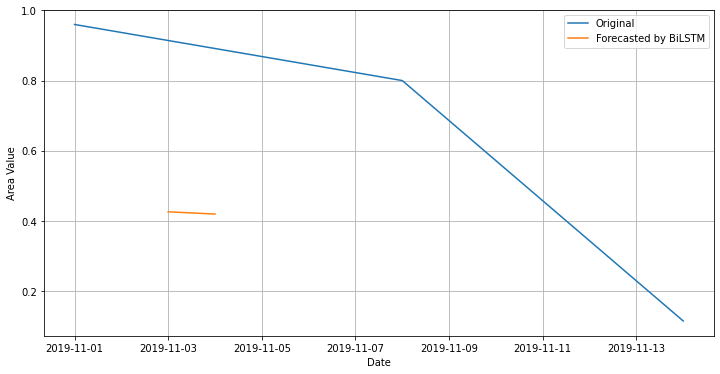

R square: 1.0 

Wound: 90
Total number of visit days after interpolation 22
1/1 [==============================] - 0s 218ms/step
test_dates shape: (3,)
predicted_values_test_inverse shape: (3, 1)


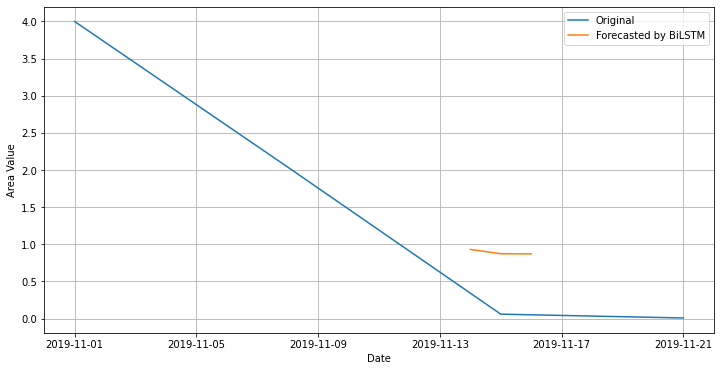

R square: 0.772 

Wound: 91
Total number of visit days after interpolation 36
1/1 [==============================] - 0s 221ms/step
test_dates shape: (6,)
predicted_values_test_inverse shape: (6, 1)


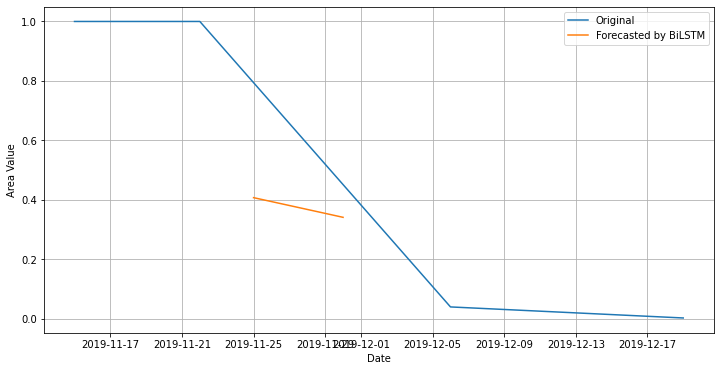

R square: 1.0 

Wound: 92
Total number of visit days after interpolation 190
2/2 [==============================] - 0s 2ms/step
test_dates shape: (37,)
predicted_values_test_inverse shape: (37, 1)


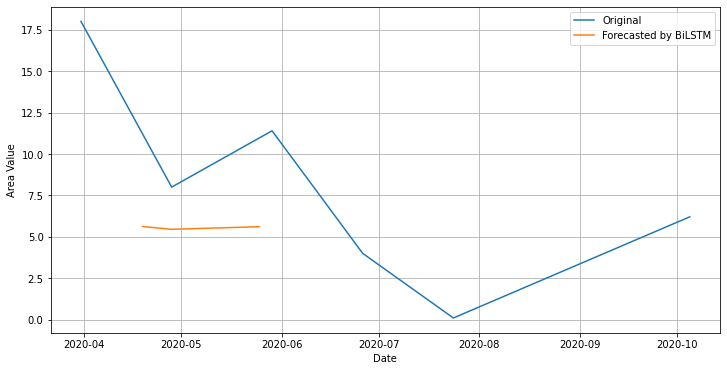

R square: 0.9513 

Wound: 93
Wound: 94
Wound: 95
Total number of visit days after interpolation 415
3/3 [==============================] - 0s 1ms/step
test_dates shape: (82,)
predicted_values_test_inverse shape: (82, 1)


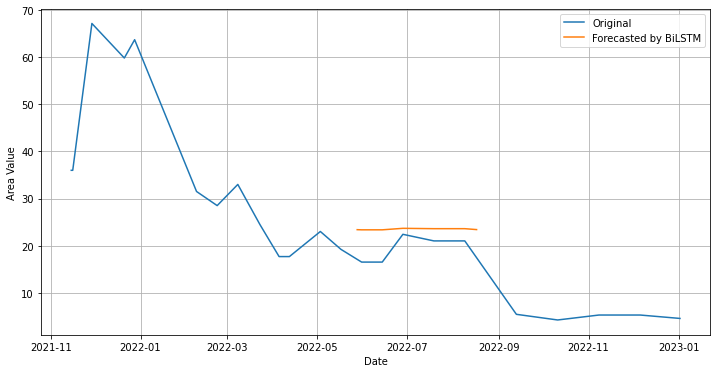

R square: 0.9872 

Wound: 96
Total number of visit days after interpolation 29
1/1 [==============================] - 0s 238ms/step
test_dates shape: (4,)
predicted_values_test_inverse shape: (4, 1)


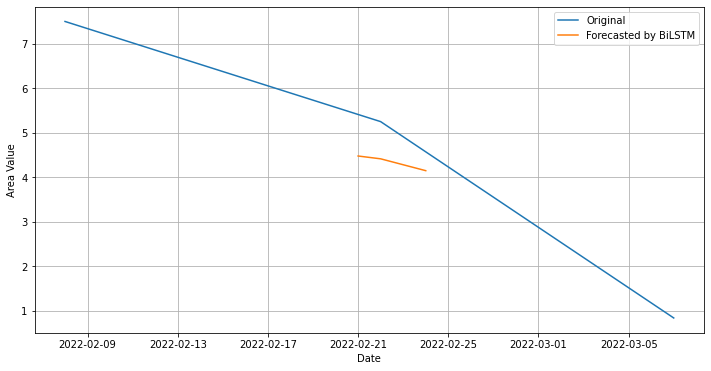

R square: 0.9773 

Wound: 97
Total number of visit days after interpolation 50
1/1 [==============================] - 0s 216ms/step
test_dates shape: (9,)
predicted_values_test_inverse shape: (9, 1)


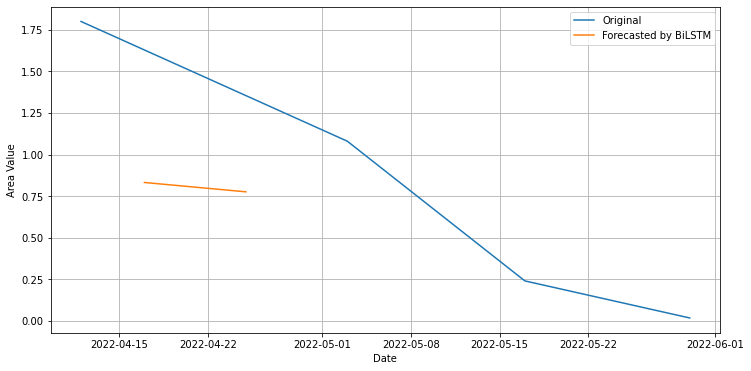

R square: 1.0 

Wound: 98
Total number of visit days after interpolation 22
1/1 [==============================] - 0s 230ms/step
test_dates shape: (3,)
predicted_values_test_inverse shape: (3, 1)


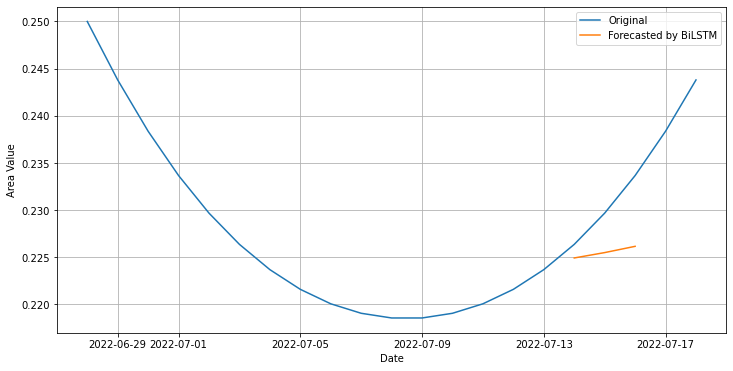

R square: 1.0 

Wound: 99
Total number of visit days after interpolation 85
1/1 [==============================] - 0s 212ms/step
test_dates shape: (16,)
predicted_values_test_inverse shape: (16, 1)


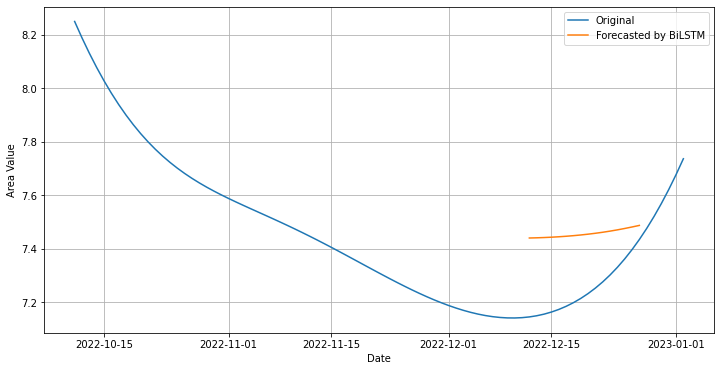

R square: 0.9998 

Wound: 100
Total number of visit days after interpolation 153
1/1 [==============================] - 0s 244ms/step
test_dates shape: (29,)
predicted_values_test_inverse shape: (29, 1)


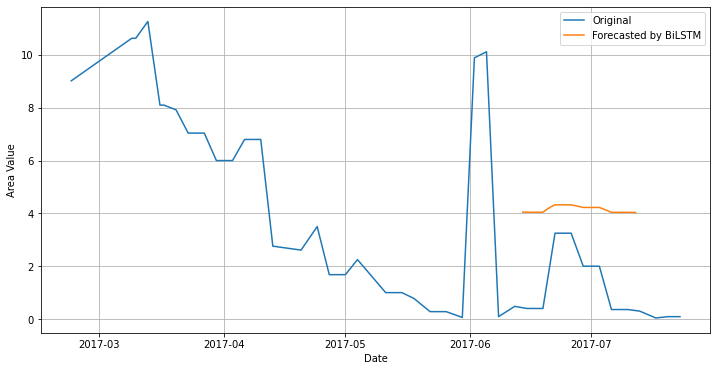

R square: 0.8861 

Wound: 101
Total number of visit days after interpolation 1129
7/7 [==============================] - 0s 1ms/step
test_dates shape: (224,)
predicted_values_test_inverse shape: (224, 1)


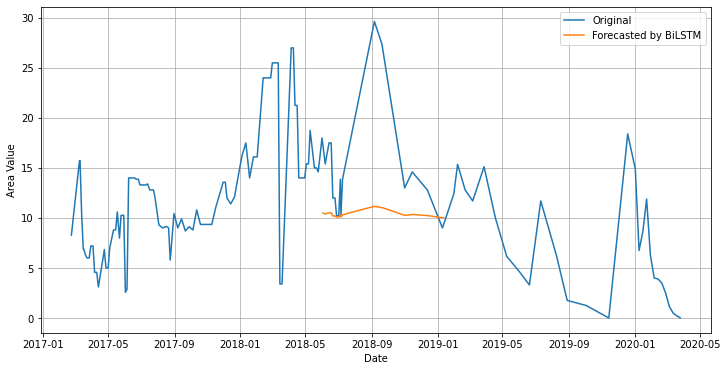

R square: 0.9934 

Wound: 102
Total number of visit days after interpolation 1026
7/7 [==============================] - 0s 1ms/step
test_dates shape: (204,)
predicted_values_test_inverse shape: (204, 1)


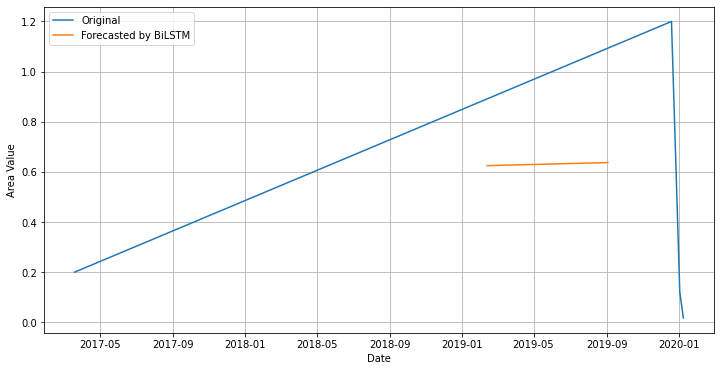

R square: 0.9999 

Wound: 103
Total number of visit days after interpolation 22
1/1 [==============================] - 0s 212ms/step
test_dates shape: (3,)
predicted_values_test_inverse shape: (3, 1)


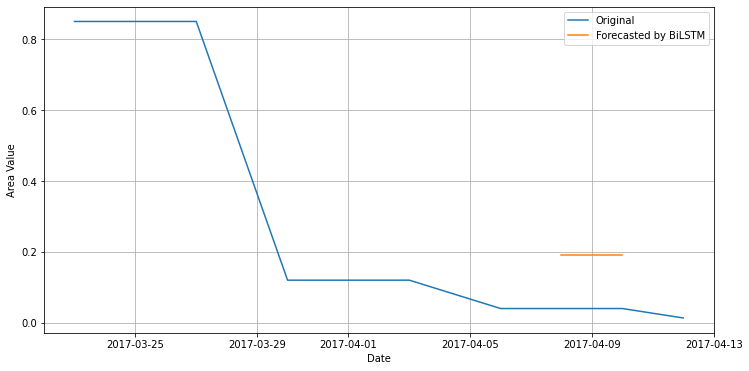

R square: nan 

Wound: 104
Total number of visit days after interpolation 15
1/1 [==============================] - 0s 216ms/step
test_dates shape: (2,)
predicted_values_test_inverse shape: (2, 1)


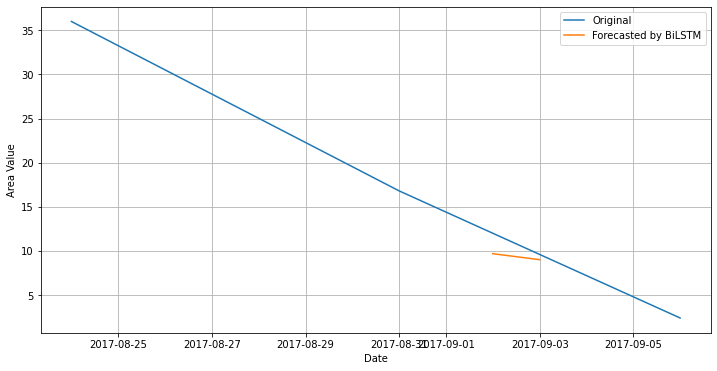

R square: 1.0 

Wound: 105
Total number of visit days after interpolation 393
3/3 [==============================] - 0s 1ms/step
test_dates shape: (77,)
predicted_values_test_inverse shape: (77, 1)


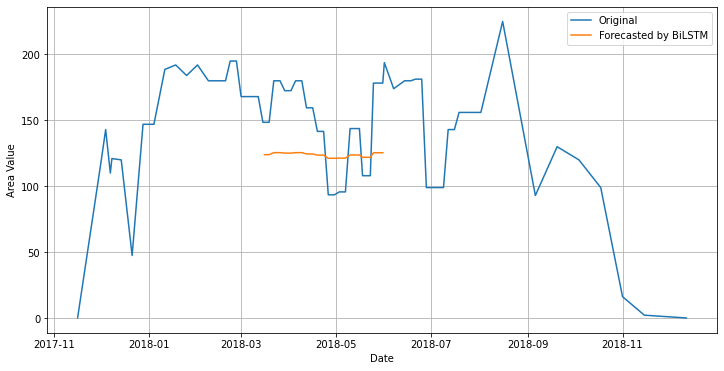

R square: 0.9277 

Wound: 106
Total number of visit days after interpolation 232
2/2 [==============================] - 0s 1ms/step
test_dates shape: (45,)
predicted_values_test_inverse shape: (45, 1)


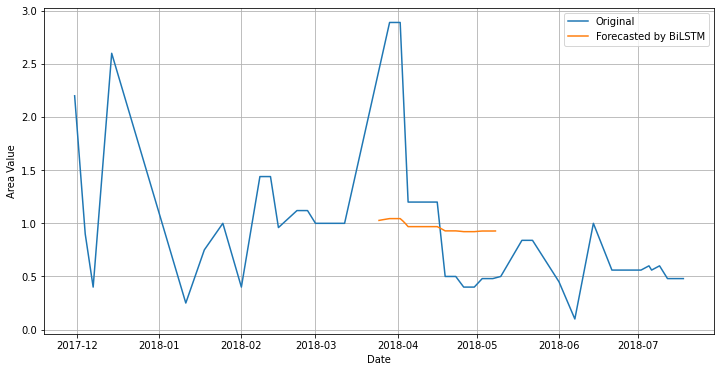

R square: 0.9597 

Wound: 107
Total number of visit days after interpolation 78
1/1 [==============================] - 0s 219ms/step
test_dates shape: (14,)
predicted_values_test_inverse shape: (14, 1)


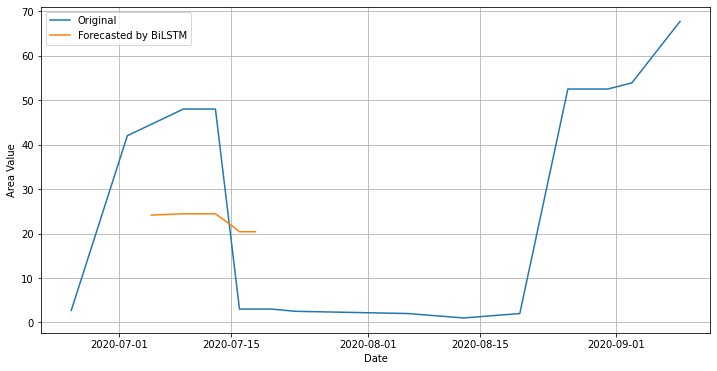

R square: 0.8922 

Wound: 108
Total number of visit days after interpolation 71
1/1 [==============================] - 0s 218ms/step
test_dates shape: (13,)
predicted_values_test_inverse shape: (13, 1)


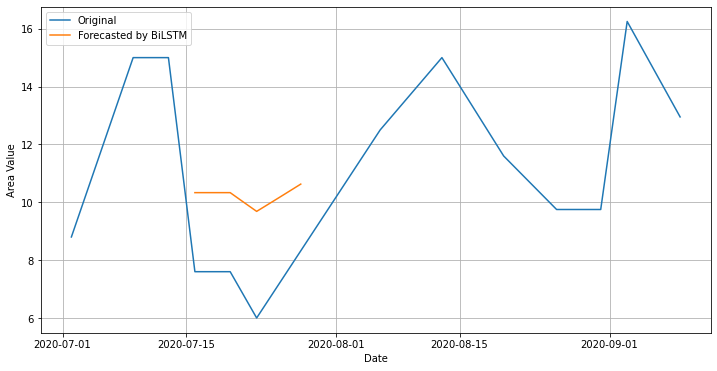

R square: 0.7119 

Wound: 109
Total number of visit days after interpolation 28
1/1 [==============================] - 0s 218ms/step
test_dates shape: (4,)
predicted_values_test_inverse shape: (4, 1)


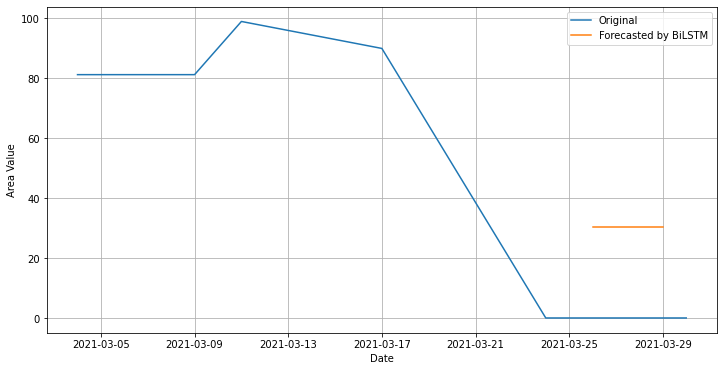

R square: nan 

Wound: 110
Total number of visit days after interpolation 70
1/1 [==============================] - 0s 220ms/step
test_dates shape: (13,)
predicted_values_test_inverse shape: (13, 1)


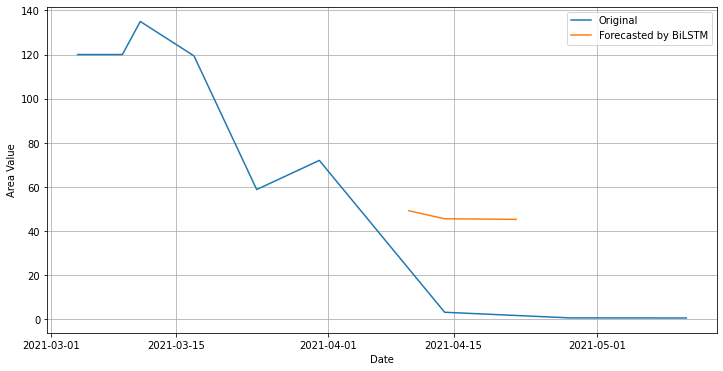

R square: 0.9592 

Wound: 111
Total number of visit days after interpolation 444
3/3 [==============================] - 0s 1ms/step
test_dates shape: (87,)
predicted_values_test_inverse shape: (87, 1)


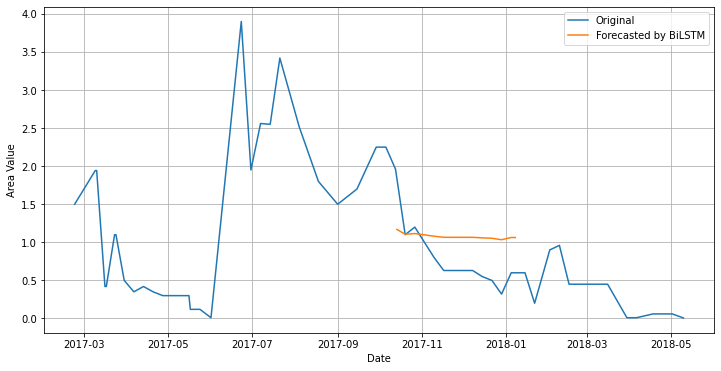

R square: 0.9917 

Wound: 112
Total number of visit days after interpolation 15
1/1 [==============================] - 0s 221ms/step
test_dates shape: (2,)
predicted_values_test_inverse shape: (2, 1)


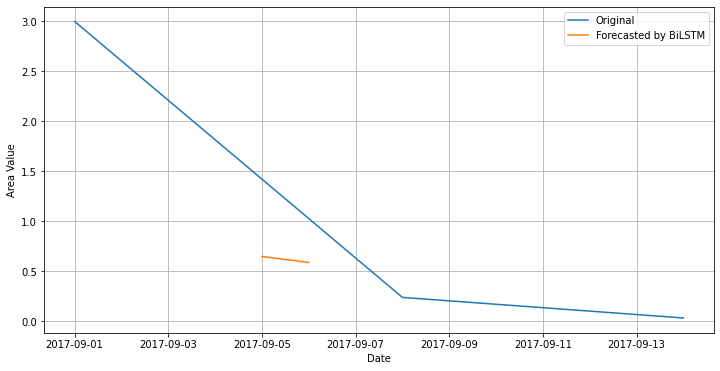

R square: 1.0 

Wound: 113
Total number of visit days after interpolation 41
1/1 [==============================] - 0s 215ms/step
test_dates shape: (7,)
predicted_values_test_inverse shape: (7, 1)


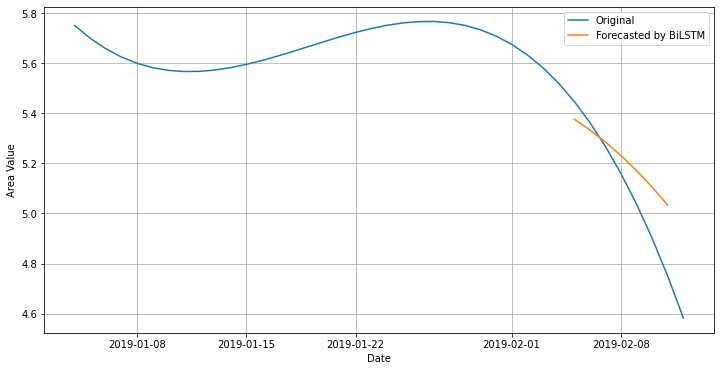

R square: 1.0 

Wound: 114
Total number of visit days after interpolation 37
1/1 [==============================] - 0s 221ms/step
test_dates shape: (6,)
predicted_values_test_inverse shape: (6, 1)


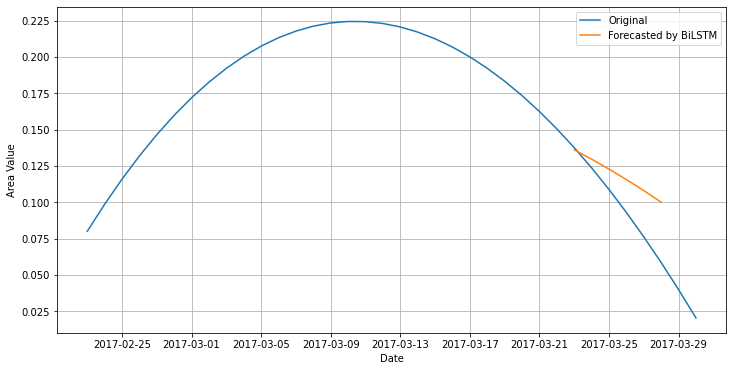

R square: 1.0 

Wound: 115
Total number of visit days after interpolation 43
1/1 [==============================] - 0s 241ms/step
test_dates shape: (7,)
predicted_values_test_inverse shape: (7, 1)


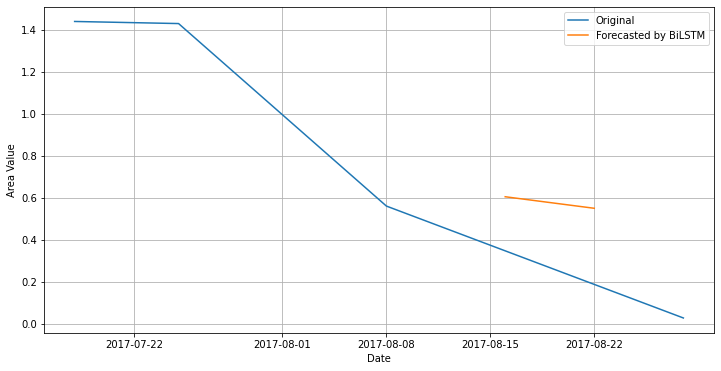

R square: 1.0 

Wound: 116
Total number of visit days after interpolation 36
1/1 [==============================] - 0s 225ms/step
test_dates shape: (6,)
predicted_values_test_inverse shape: (6, 1)


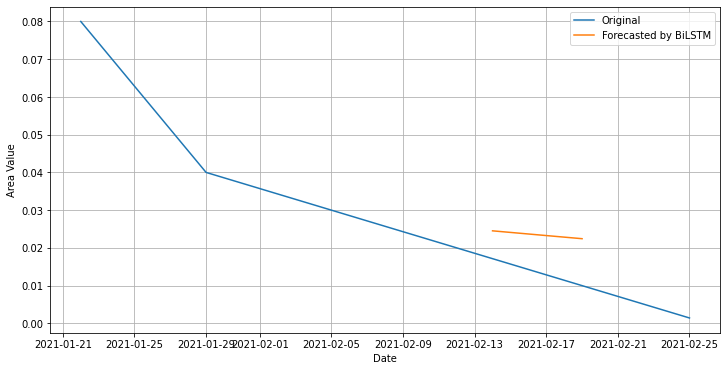

R square: 1.0 

Wound: 117
Total number of visit days after interpolation 91
1/1 [==============================] - 0s 220ms/step
test_dates shape: (17,)
predicted_values_test_inverse shape: (17, 1)


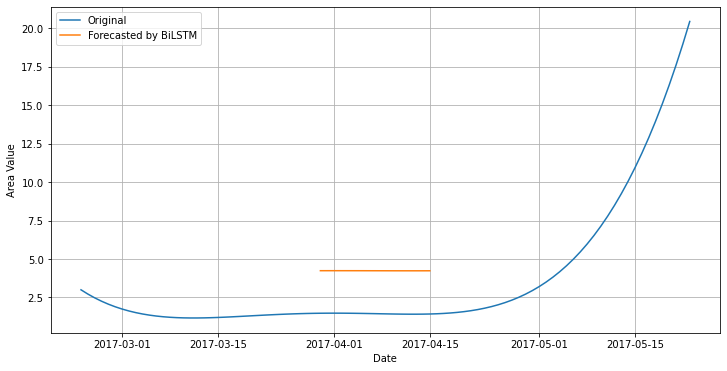

R square: 0.936 

Wound: 118
Total number of visit days after interpolation 30
1/1 [==============================] - 0s 213ms/step
test_dates shape: (5,)
predicted_values_test_inverse shape: (5, 1)


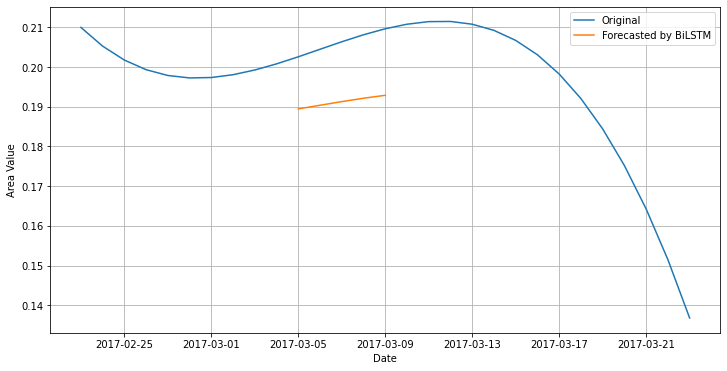

R square: 0.9975 

Wound: 119
Total number of visit days after interpolation 36
1/1 [==============================] - 0s 216ms/step
test_dates shape: (6,)
predicted_values_test_inverse shape: (6, 1)


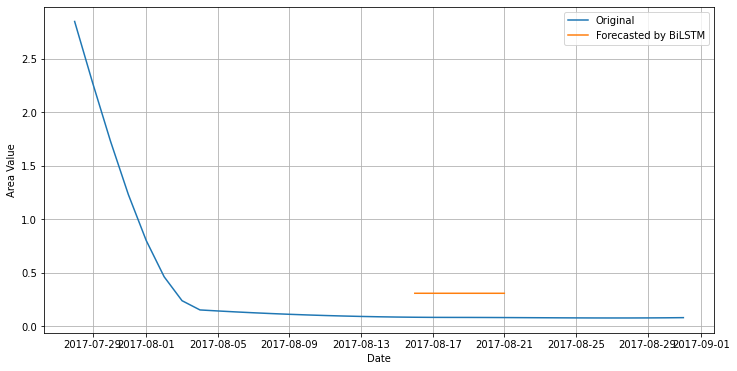

R square: 0.8994 

Wound: 120
Total number of visit days after interpolation 22
1/1 [==============================] - 0s 222ms/step
test_dates shape: (3,)
predicted_values_test_inverse shape: (3, 1)


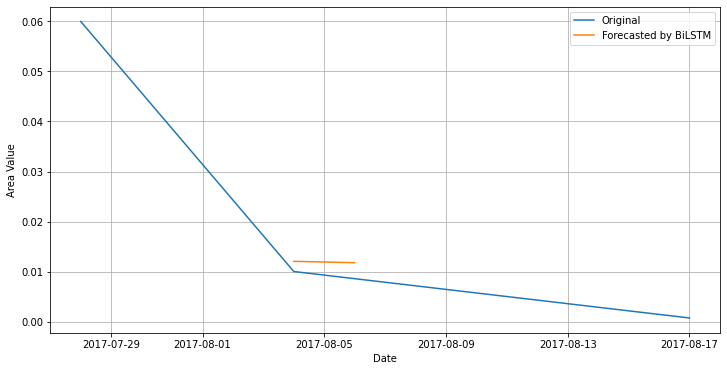

R square: 1.0 

Wound: 121
Total number of visit days after interpolation 36
1/1 [==============================] - 0s 223ms/step
test_dates shape: (6,)
predicted_values_test_inverse shape: (6, 1)


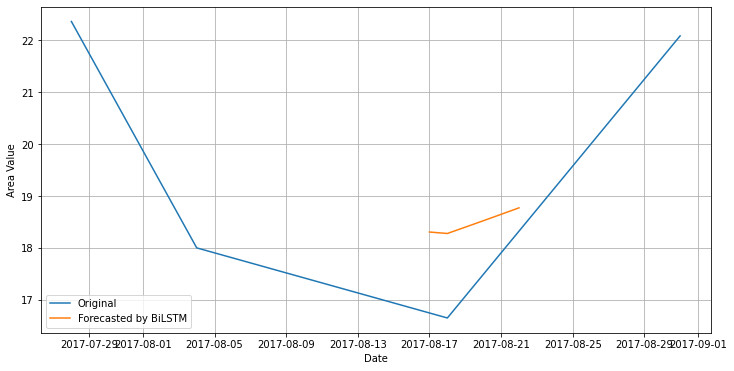

R square: 0.9422 

Wound: 122
Total number of visit days after interpolation 294
2/2 [==============================] - 0s 2ms/step
test_dates shape: (57,)
predicted_values_test_inverse shape: (57, 1)


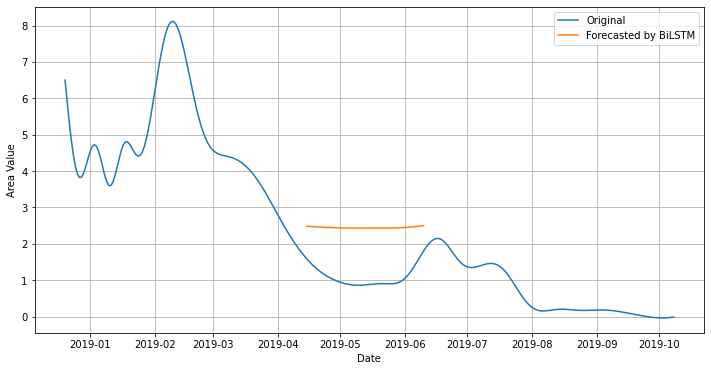

R square: 0.9727 

Wound: 123
Total number of visit days after interpolation 93
1/1 [==============================] - 0s 225ms/step
test_dates shape: (17,)
predicted_values_test_inverse shape: (17, 1)


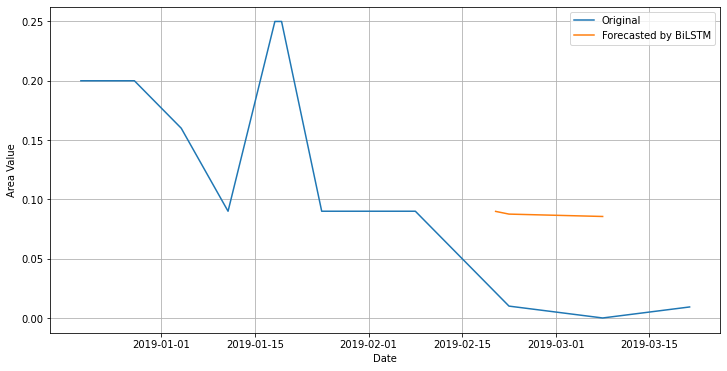

R square: 0.9515 

Wound: 124
Total number of visit days after interpolation 162
1/1 [==============================] - 0s 218ms/step
test_dates shape: (31,)
predicted_values_test_inverse shape: (31, 1)


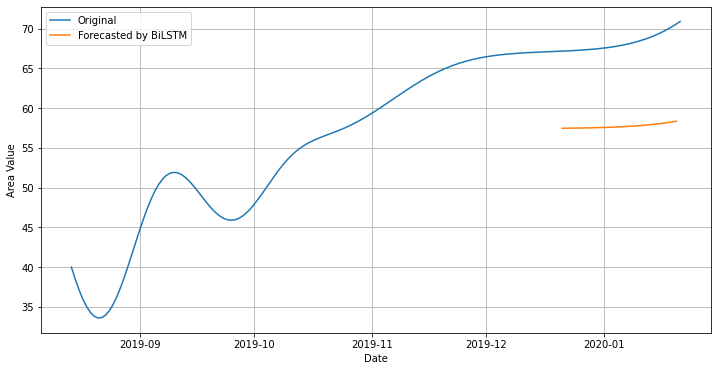

R square: 1.0 

Wound: 125
Total number of visit days after interpolation 50
1/1 [==============================] - 0s 221ms/step
test_dates shape: (9,)
predicted_values_test_inverse shape: (9, 1)


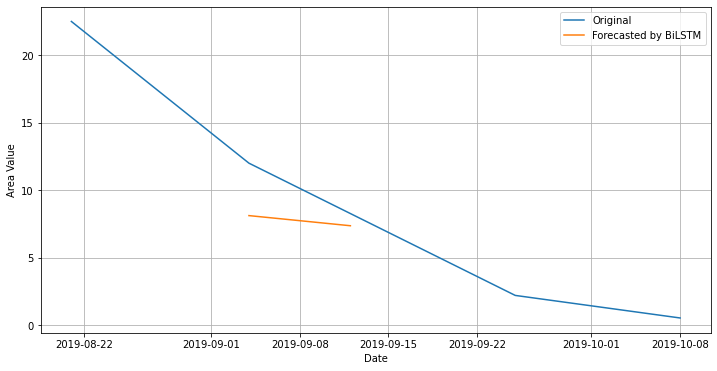

R square: 1.0 

Wound: 126
Total number of visit days after interpolation 36
1/1 [==============================] - 0s 224ms/step
test_dates shape: (6,)
predicted_values_test_inverse shape: (6, 1)


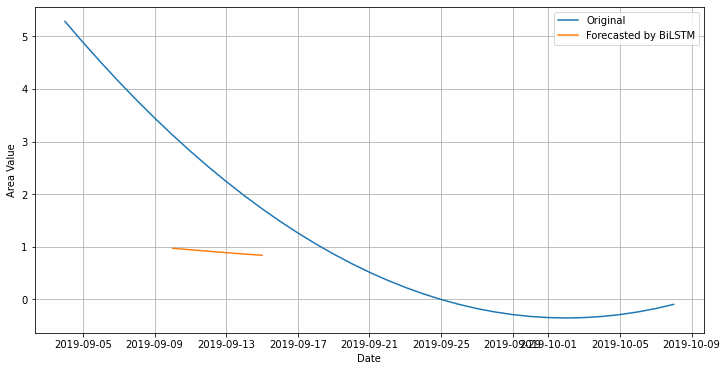

R square: 1.0 

Wound: 127
Total number of visit days after interpolation 50
1/1 [==============================] - 0s 224ms/step
test_dates shape: (9,)
predicted_values_test_inverse shape: (9, 1)


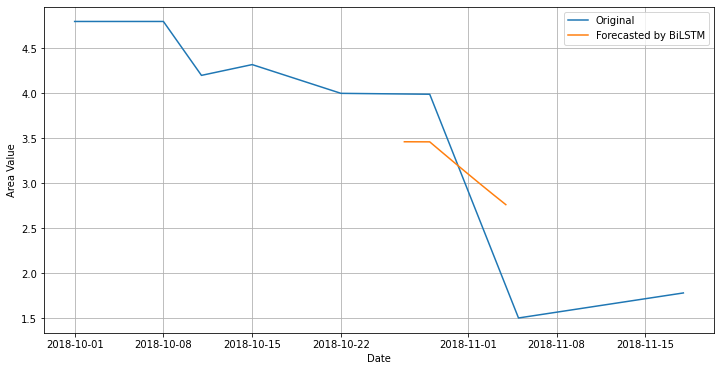

R square: 0.9816 

Wound: 128
Total number of visit days after interpolation 15
1/1 [==============================] - 0s 219ms/step
test_dates shape: (2,)
predicted_values_test_inverse shape: (2, 1)


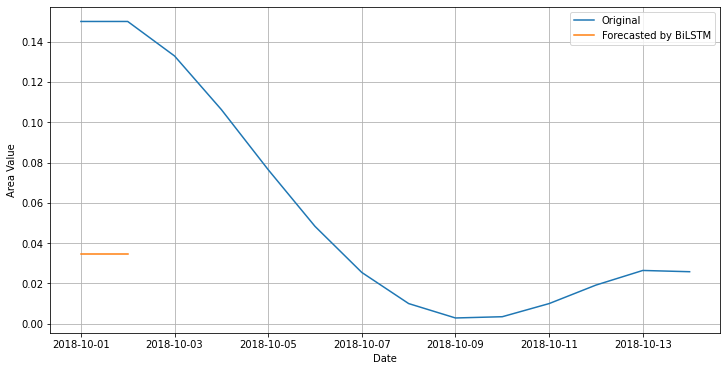

R square: nan 

Wound: 129
Total number of visit days after interpolation 86
1/1 [==============================] - 0s 220ms/step
test_dates shape: (16,)
predicted_values_test_inverse shape: (16, 1)


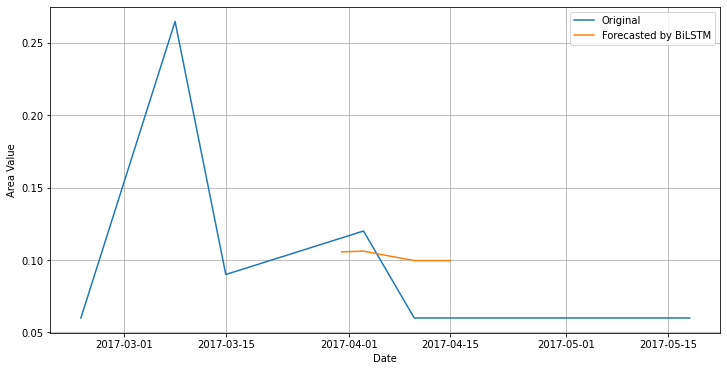

R square: 0.9666 

Wound: 130
Total number of visit days after interpolation 170
2/2 [==============================] - 0s 1ms/step
test_dates shape: (33,)
predicted_values_test_inverse shape: (33, 1)


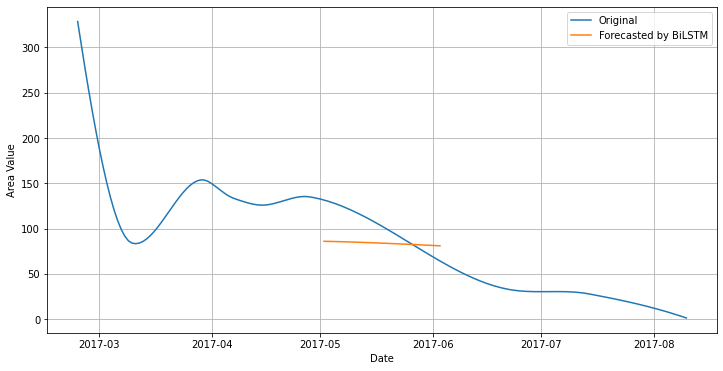

R square: 0.9991 

Wound: 131
Total number of visit days after interpolation 36
1/1 [==============================] - 0s 216ms/step
test_dates shape: (6,)
predicted_values_test_inverse shape: (6, 1)


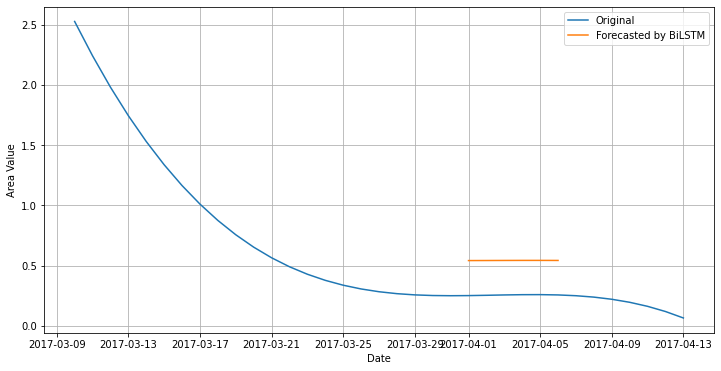

R square: 0.1256 

Wound: 132
Total number of visit days after interpolation 36
1/1 [==============================] - 0s 220ms/step
test_dates shape: (6,)
predicted_values_test_inverse shape: (6, 1)


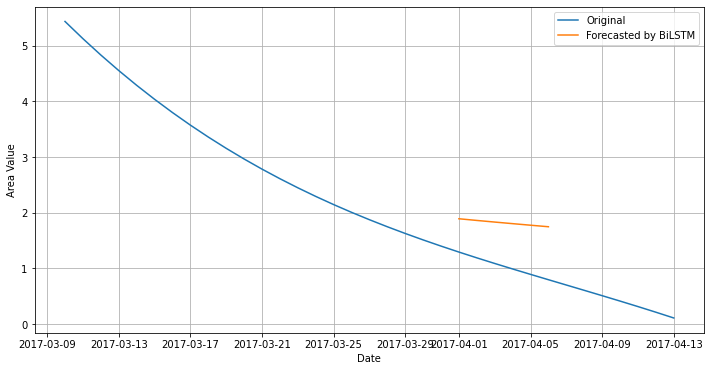

R square: 1.0 

Wound: 133
Total number of visit days after interpolation 190
2/2 [==============================] - 0s 2ms/step
test_dates shape: (37,)
predicted_values_test_inverse shape: (37, 1)


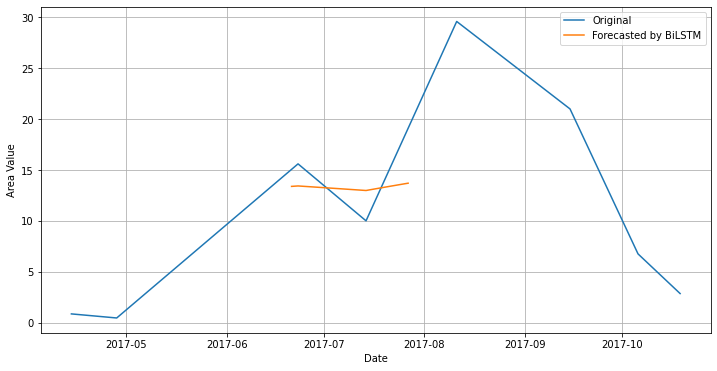

R square: 0.9687 

Wound: 134
Total number of visit days after interpolation 137
1/1 [==============================] - 0s 238ms/step
test_dates shape: (26,)
predicted_values_test_inverse shape: (26, 1)


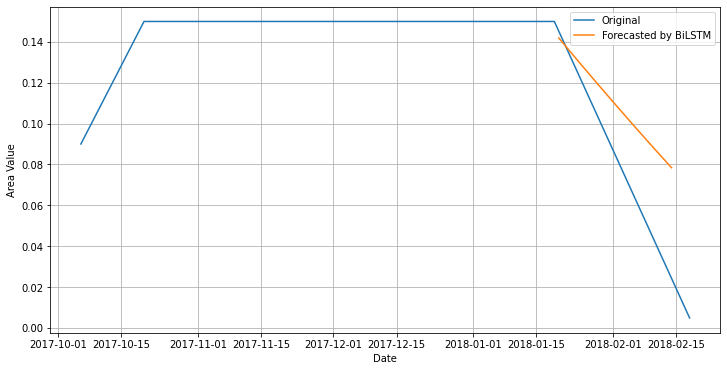

R square: 0.9999 

Wound: 135
Total number of visit days after interpolation 127
1/1 [==============================] - 0s 228ms/step
test_dates shape: (24,)
predicted_values_test_inverse shape: (24, 1)


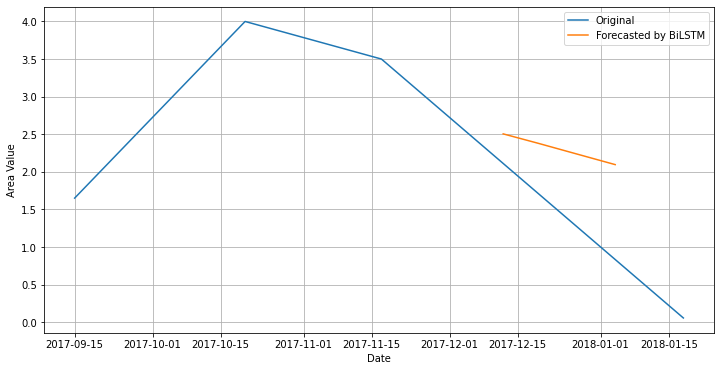

R square: 1.0 

Wound: 136
Total number of visit days after interpolation 61
1/1 [==============================] - 0s 219ms/step
test_dates shape: (11,)
predicted_values_test_inverse shape: (11, 1)


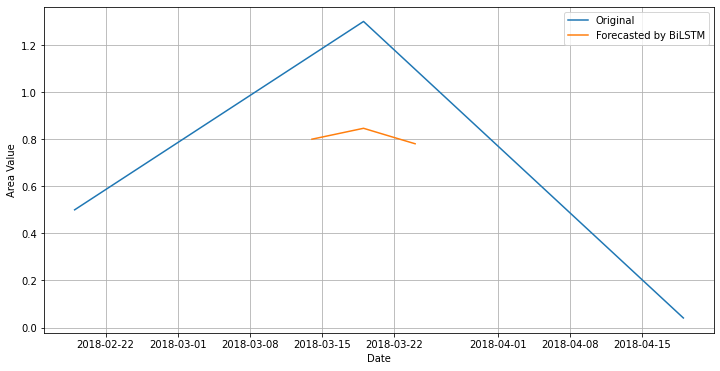

R square: 0.7734 

Wound: 137
Total number of visit days after interpolation 61
1/1 [==============================] - 0s 222ms/step
test_dates shape: (11,)
predicted_values_test_inverse shape: (11, 1)


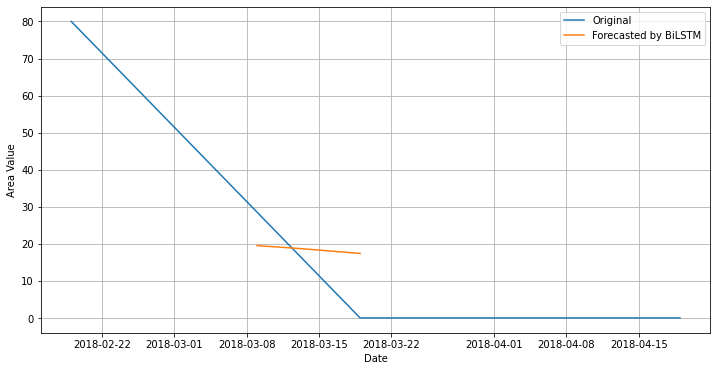

R square: 0.9895 

Wound: 138
Total number of visit days after interpolation 75
1/1 [==============================] - 0s 218ms/step
test_dates shape: (14,)
predicted_values_test_inverse shape: (14, 1)


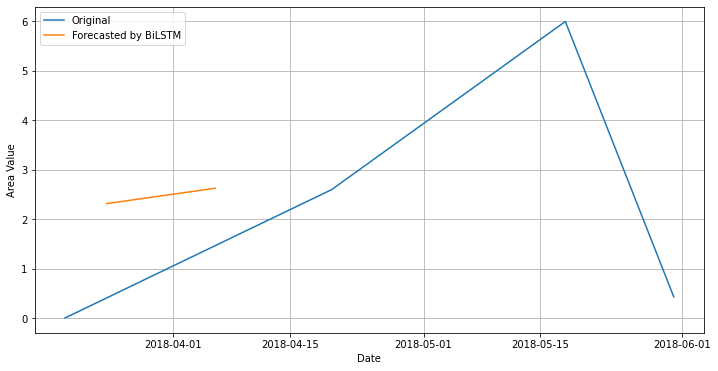

R square: 1.0 

Wound: 139
Total number of visit days after interpolation 61
1/1 [==============================] - 0s 211ms/step
test_dates shape: (11,)
predicted_values_test_inverse shape: (11, 1)


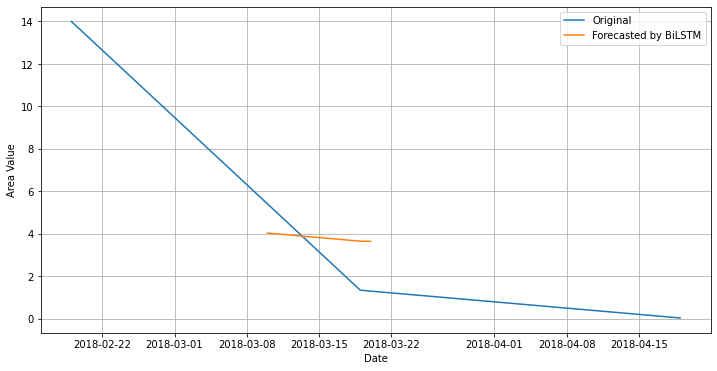

R square: 0.9893 

Wound: 140
Wound: 141
Total number of visit days after interpolation 393
3/3 [==============================] - 0s 978us/step
test_dates shape: (77,)
predicted_values_test_inverse shape: (77, 1)


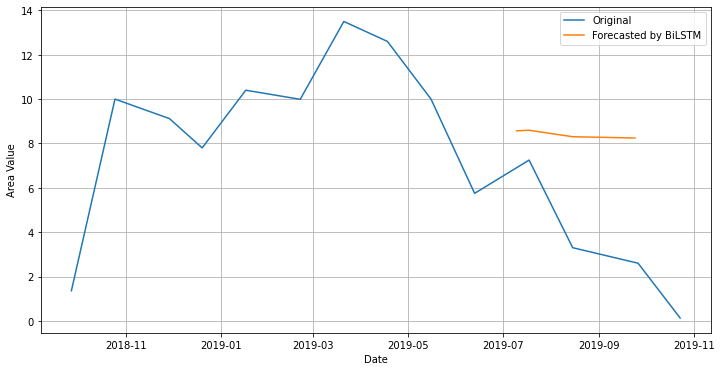

R square: 0.9977 

Wound: 142
Total number of visit days after interpolation 365
3/3 [==============================] - 0s 1ms/step
test_dates shape: (72,)
predicted_values_test_inverse shape: (72, 1)


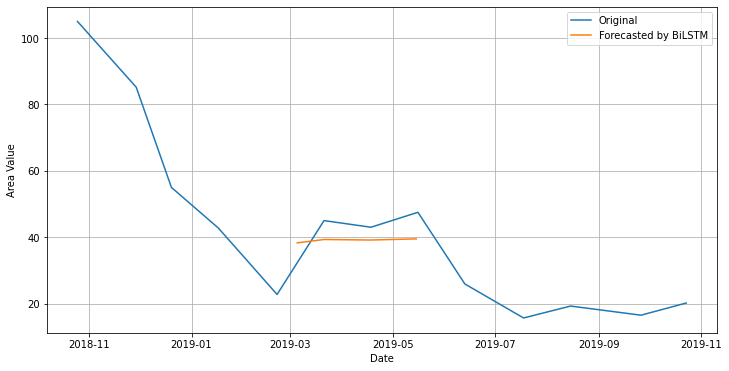

R square: 0.9944 

Wound: 143
Total number of visit days after interpolation 330
3/3 [==============================] - 0s 1ms/step
test_dates shape: (65,)
predicted_values_test_inverse shape: (65, 1)


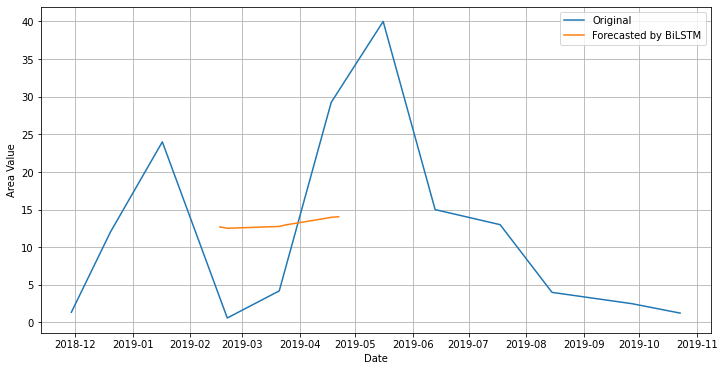

R square: 0.9983 

Wound: 144
Total number of visit days after interpolation 192


KeyboardInterrupt: 

In [44]:
list_wounds=df_for["Wound"].unique()

result_df=pd.DataFrame(index=np.arange(len(list_wounds)))

result_df["Wound"]=np.nan
result_df["Gender"]=np.nan
result_df["Race"]=np.nan
result_df["Ethinicity"]=np.nan
result_df["RMSE"]=np.nan
result_df["MASE"]=np.nan
result_df["R-squared"]=np.nan
    

for i in range(0,len(list_wounds)):
#     if i>4:
#         break
    print("Wound:",i+1)
    wound=list_wounds[i]
    df_1=df_for.query("Wound==@wound")
    #display(df_1)
    df=df_1[["Date","Area"]]
    
    if df.shape[0]>9 and df.shape[0]<1200:
    
    #test,train,df=make_input_for_lstm(df)


        result_df["Wound"][i]=int(df_1["Wound"].unique()[0])
        result_df["Gender"][i]=str(df_1["Gender"].unique()[0])
        result_df["Race"][i]=str(df_1["Race"].unique()[0])
        result_df["Ethinicity"][i]=str(df_1["Ethinicity"].unique()[0])


        rmse, mase, r_square=model_BiLSTM(df)
        result_df["RMSE"][i]=rmse
        result_df["MASE"][i]=mase
        result_df["R-squared"][i]=r_square
        print("R square:",round(r_square,4),"\n")

result_df["Wound"]=result_df["Wound"].astype(int)

In [59]:
i

14917

In [60]:
len(list_wounds)

14918

In [61]:
result_df

,Wound,Gender,Race,Ethinicity,RMSE,MASE,R-squared
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
14913,17877.0,M,White,Non-Hispanic,0.618621,152.698720,NaN
14914,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14915,17880.0,F,White,Non-Hispanic,0.631697,87.089956,1.0
14916,17881.0,M,White,Non-Hispanic,1.729405,638.033164,NaN


In [62]:
result_df=result_df.dropna(how='all')
result_df

,Wound,Gender,Race,Ethinicity,RMSE,MASE,R-squared
7445,9499.0,F,Black,Non-Hispanic,8.205459,1075.958487,0.983126
7446,9500.0,F,Black,Non-Hispanic,14.164679,163.592619,NaN
7447,9501.0,F,White,Hispanic,0.037206,5.643829,0.998811
7448,9502.0,F,White,Non-Hispanic,0.143630,3.383022,0.959200
7449,9503.0,F,White,Non-Hispanic,1.419943,348.768901,0.980843
...,...,...,...,...,...,...,...
14911,17875.0,F,White,Non-Hispanic,0.042408,14.117079,1.000000
14912,17876.0,F,White,Non-Hispanic,0.300154,205.408805,1.000000
14913,17877.0,M,White,Non-Hispanic,0.618621,152.698720,NaN
14915,17880.0,F,White,Non-Hispanic,0.631697,87.089956,1.000000


In [63]:
prev_result_df=pd.read_csv("BiLSTM_result.csv")
prev_result_df=prev_result_df.drop(["Unnamed: 0"],axis=1)
prev_result_df

,Wound,Gender,Race,Ethinicity,RMSE,MASE,R-squared
0,1.0,M,White,Non-Hispanic,1.832574,94.877522,0.913301
1,2.0,M,White,Non-Hispanic,2.369196,9.332101,0.685230
2,3.0,M,White,Non-Hispanic,0.003671,3.659552,NaN
3,5.0,M,White,Non-Hispanic,1.736090,13.397815,1.000000
4,6.0,M,White,Non-Hispanic,0.096517,3.330987,1.000000
...,...,...,...,...,...,...,...
6991,9495.0,F,White,Non-Hispanic,0.102205,8.358970,NaN
6992,9496.0,F,White,Non-Hispanic,0.008255,16.070109,0.950350
6993,9497.0,F,White,Non-Hispanic,0.071531,2.506655,0.777788
6994,9498.0,F,White,Non-Hispanic,0.035028,3.069555,0.608949


In [64]:
prev_result_df=prev_result_df.dropna(how='all')
prev_result_df

,Wound,Gender,Race,Ethinicity,RMSE,MASE,R-squared
0,1.0,M,White,Non-Hispanic,1.832574,94.877522,0.913301
1,2.0,M,White,Non-Hispanic,2.369196,9.332101,0.685230
2,3.0,M,White,Non-Hispanic,0.003671,3.659552,NaN
3,5.0,M,White,Non-Hispanic,1.736090,13.397815,1.000000
4,6.0,M,White,Non-Hispanic,0.096517,3.330987,1.000000
...,...,...,...,...,...,...,...
6991,9495.0,F,White,Non-Hispanic,0.102205,8.358970,NaN
6992,9496.0,F,White,Non-Hispanic,0.008255,16.070109,0.950350
6993,9497.0,F,White,Non-Hispanic,0.071531,2.506655,0.777788
6994,9498.0,F,White,Non-Hispanic,0.035028,3.069555,0.608949


In [65]:
new_df=pd.concat([prev_result_df,result_df],axis=0)
new_df

,Wound,Gender,Race,Ethinicity,RMSE,MASE,R-squared
0,1.0,M,White,Non-Hispanic,1.832574,94.877522,0.913301
1,2.0,M,White,Non-Hispanic,2.369196,9.332101,0.685230
2,3.0,M,White,Non-Hispanic,0.003671,3.659552,NaN
3,5.0,M,White,Non-Hispanic,1.736090,13.397815,1.000000
4,6.0,M,White,Non-Hispanic,0.096517,3.330987,1.000000
...,...,...,...,...,...,...,...
14911,17875.0,F,White,Non-Hispanic,0.042408,14.117079,1.000000
14912,17876.0,F,White,Non-Hispanic,0.300154,205.408805,1.000000
14913,17877.0,M,White,Non-Hispanic,0.618621,152.698720,NaN
14915,17880.0,F,White,Non-Hispanic,0.631697,87.089956,1.000000


In [66]:
new_df.to_csv("BiLSTM_result.csv")

In [53]:
## BiLSTM model is unable to predict if there is 8 or less visit days in total